Bu projede, 2019 tarihinden itibaren pandemi etkisiyle gayrimenkul sektöründe değişen konut fiyatlarını tahmin edilmek istenmektedir.

Öncelikle kütüphanelerimi ve verisetlerimi ekleyeceğim.

In [1]:
import pandas as pd
import numpy as np
pd.set_option("max_columns" , None)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, cross_val_score
pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [2]:
#conda install -c anaconda py-xgboost

In [3]:
import xgboost as xgb

In [4]:
#pip install optuna

In [5]:
import optuna

In [6]:
test = pd.read_csv('Desktop/zingat_usecase_testset_null.csv')
train = pd.read_csv('Desktop/zingat_usecase_trainset.csv')
sub = pd.read_csv('Desktop/sample_submission_zingat.csv')

In [7]:
train.head(10)

,tarih,path,güncel_fiyat,odasayısı,brütm²,netm²,emlaktipi,binayaşı,bulunduğukat,binadakikatsayısı,isıtmatipi,banyosayisi,manzara,otopark,İnterkom,depremyönetmeliğineuygun,asansör,Çocukoyunalanı,giyinmeodası,ebeveynbanyosu,Ilan_ID
0,2019-01-01,İstanbul/Beylikdüzü/Adnan Kahveci,1050000 TRY,5+2,380.000,370.000,Daire,16-20 arası,12,10-20 arası,Kombi (Doğalgaz),3,"Cadde,Deniz,Göl","Var (Ücretsiz, Kapalı)",VAR,VAR,VAR,VAR,VAR,VAR,1
1,2019-01-01,İstanbul/Kadıköy/Erenköy,547500 TRY,2+1,65.000,55.000,Daire,0,1,7,Kombi (Doğalgaz),1,_,-,VAR,YOK,VAR,YOK,YOK,YOK,11
2,2019-01-01,İstanbul/Beylikdüzü/Adnan Kahveci,440000 TRY,3+1,205.000,197.000,Daire,11-15 arası,2,10-20 arası,Kombi (Doğalgaz),2,"Cadde,Şehir","Var (Ücretsiz, Kapalı)",VAR,VAR,VAR,YOK,YOK,VAR,10
3,2019-01-01,İstanbul/Beşiktaş/Nisbetiye,1450000 TRY,3+1,150.000,130.000,Daire,26-30 arası,3,5,Merkezi Sistem (Isı Payı Ölçer),2,"Cadde,Şehir","Var (Ücretsiz, Açık)",YOK,YOK,VAR,YOK,YOK,VAR,8
4,2019-01-01,İstanbul/Beylikdüzü/Cumhuriyet,169000 TRY,2+1,70.000,65.000,Daire,1,Kot 1,6,Kombi (Doğalgaz),1,"Boğaz,Deniz,Göl,Doğa",Var,VAR,YOK,VAR,YOK,VAR,VAR,7
5,2019-01-01,İstanbul/Beylikdüzü/Cumhuriyet,180000 TRY,2+1,110.000,95.000,Daire,0,2,6,Kombi (Doğalgaz),1,Şehir,Yok,YOK,VAR,VAR,VAR,YOK,YOK,9
6,2019-01-01,İzmir/Güzelbahçe/Mustafa Kemal Paşa,695000 TRY,2+1,123.000,101.000,Daire,0,1,2,Kat Kaloriferi,1,_,"Var (Ücretsiz, Açık)",VAR,VAR,YOK,VAR,YOK,YOK,5
7,2019-01-01,İzmir/Buca/Güven,290000 TRY,3+1,135.000,125.000,Daire,16-20 arası,2,5,Kombi (Doğalgaz),1,_,-,YOK,YOK,YOK,YOK,YOK,YOK,4
8,2019-01-01,İzmir/Karşıyaka/Örnekköy,349000 TRY,3+1,130.000,115.000,Daire,2,2,3,Kombi (Doğalgaz),1,_,-,YOK,YOK,YOK,YOK,YOK,YOK,3
9,2019-01-01,İzmir/Torbalı/Dirmil,285000 TRY,1+1,67.000,42.000,Müstakil Ev,-,-,-,-,1,_,-,YOK,YOK,YOK,YOK,YOK,YOK,2


In [8]:
test.head(10)

,tarih,path,odasayısı,brütm²,netm²,emlaktipi,binayaşı,bulunduğukat,binadakikatsayısı,isıtmatipi,banyosayisi,manzara,otopark,İnterkom,depremyönetmeliğineuygun,asansör,Çocukoyunalanı,giyinmeodası,ebeveynbanyosu,Ilan_ID,güncel_fiyat
0,2020-04-20,İzmir/Konak/Güzelyalı,4+1,165.000,155.000,Daire,31-35 arası,6,7,Kombi (Doğalgaz),1,_,-,YOK,YOK,YOK,YOK,VAR,YOK,64650,NaN
1,2020-04-20,İzmir/Ödemiş/İnönü,2+1,130.000,120.000,Daire,6-10 arası,2,2,Klima,1,_,-,YOK,YOK,YOK,YOK,YOK,YOK,64651,NaN
2,2020-04-20,İzmir/Karşıyaka/Örnekköy,3+1,182.000,153.000,Daire,0,7,10-20 arası,Yerden Isıtma,2,_,-,YOK,YOK,YOK,YOK,YOK,YOK,64652,NaN
3,2020-04-20,İzmir/Ödemiş/İnönü,2+1,130.000,120.000,Daire,6-10 arası,2,2,Klima,1,_,-,YOK,YOK,YOK,YOK,YOK,YOK,64653,NaN
4,2020-04-20,İstanbul/Beylikdüzü/Kavaklı,3+1,125.000,120.000,Daire,0,6,6,Kombi (Doğalgaz),1,"Boğaz,Cadde,Dağ,Deniz,Doğa,Göl",-,VAR,VAR,VAR,VAR,VAR,VAR,64654,NaN
5,2020-04-20,İstanbul/Kadıköy/Suadiye,2+1,100.000,80.000,Daire,0,2,4,Klima,1,"Doğa,Şehir",-,VAR,YOK,VAR,YOK,YOK,YOK,64658,NaN
6,2020-04-20,İstanbul/Beylikdüzü/Beylikdüzü OSB,3+1,155.000,145.000,Daire,1,3,6,Kombi (Doğalgaz),2,"Cadde,Doğa,Park,Şehir,Yeşil Alan",-,VAR,VAR,VAR,VAR,VAR,VAR,64656,NaN
7,2020-04-20,İstanbul/Kadıköy/Suadiye,3+1,179.000,155.000,Daire,31-35 arası,4,4,Merkezi Sistem,2,_,-,VAR,YOK,YOK,YOK,YOK,YOK,64657,NaN
8,2020-04-20,İzmir/Menemen/Villakent,5+2,1350.000,400.000,Villa,6-10 arası,3,3,Kombi (Doğalgaz),3,_,-,YOK,YOK,YOK,YOK,YOK,YOK,64649,NaN
9,2020-04-20,İstanbul/Beylikdüzü/Cumhuriyet,3+1,130.000,120.000,Daire,0,2,5,Kombi (Doğalgaz),2,"Boğaz,Deniz,Doğa,Göl,Şehir",Var,VAR,YOK,VAR,YOK,VAR,VAR,64659,NaN


In [9]:
sub.head()

,Id,Expected
0,64650,0
1,64651,0
2,64652,0
3,64653,0
4,64654,0


Verisetlerime göz gezdirdikten sonra ilk olarak Türkçe karakterler arındırıyorum.

In [10]:
train["güncel_fiyat"] = train["güncel_fiyat"].str.strip("TRY")
train["güncel_fiyat"] = train["güncel_fiyat"].astype(int)

In [11]:
train.head(3)

,tarih,path,güncel_fiyat,odasayısı,brütm²,netm²,emlaktipi,binayaşı,bulunduğukat,binadakikatsayısı,isıtmatipi,banyosayisi,manzara,otopark,İnterkom,depremyönetmeliğineuygun,asansör,Çocukoyunalanı,giyinmeodası,ebeveynbanyosu,Ilan_ID
0,2019-01-01,İstanbul/Beylikdüzü/Adnan Kahveci,1050000,5+2,380.000,370.000,Daire,16-20 arası,12,10-20 arası,Kombi (Doğalgaz),3,"Cadde,Deniz,Göl","Var (Ücretsiz, Kapalı)",VAR,VAR,VAR,VAR,VAR,VAR,1
1,2019-01-01,İstanbul/Kadıköy/Erenköy,547500,2+1,65.000,55.000,Daire,0,1,7,Kombi (Doğalgaz),1,_,-,VAR,YOK,VAR,YOK,YOK,YOK,11
2,2019-01-01,İstanbul/Beylikdüzü/Adnan Kahveci,440000,3+1,205.000,197.000,Daire,11-15 arası,2,10-20 arası,Kombi (Doğalgaz),2,"Cadde,Şehir","Var (Ücretsiz, Kapalı)",VAR,VAR,VAR,YOK,YOK,VAR,10


Kontrol ettiğimde güncel fiyat değerinin TRY ibaresinden kurtulduğunu onaylıyorum. Bu değeri integer olarak kullanacağım için içerisinde sözel ifade barındırmasını istemedim.

In [12]:
train.columns = ['tarih','konum','guncelfiyat','odasayisi','brutm2','netm2','emlaktipi','binayasi','bulundugukat',
                'toplamkat','isitma','banyosayisi','manzara','otopark','interkom','depremyonuyg','asansor','oyunalani','giyinmeodasi','ebeveynbanyosu','id']
test.columns = ['tarih','konum','odasayisi','brutm2','netm2','emlaktipi','binayasi','bulundugukat',
                'toplamkat','isitma','banyosayisi','manzara','otopark','interkom','depremyonuyg','asansor','oyunalani','giyinmeodasi','ebeveynbanyosu','id','guncelfiyat']

In [13]:
train.head()

,tarih,konum,guncelfiyat,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id
0,2019-01-01,İstanbul/Beylikdüzü/Adnan Kahveci,1050000,5+2,380.000,370.000,Daire,16-20 arası,12,10-20 arası,Kombi (Doğalgaz),3,"Cadde,Deniz,Göl","Var (Ücretsiz, Kapalı)",VAR,VAR,VAR,VAR,VAR,VAR,1
1,2019-01-01,İstanbul/Kadıköy/Erenköy,547500,2+1,65.000,55.000,Daire,0,1,7,Kombi (Doğalgaz),1,_,-,VAR,YOK,VAR,YOK,YOK,YOK,11
2,2019-01-01,İstanbul/Beylikdüzü/Adnan Kahveci,440000,3+1,205.000,197.000,Daire,11-15 arası,2,10-20 arası,Kombi (Doğalgaz),2,"Cadde,Şehir","Var (Ücretsiz, Kapalı)",VAR,VAR,VAR,YOK,YOK,VAR,10
3,2019-01-01,İstanbul/Beşiktaş/Nisbetiye,1450000,3+1,150.000,130.000,Daire,26-30 arası,3,5,Merkezi Sistem (Isı Payı Ölçer),2,"Cadde,Şehir","Var (Ücretsiz, Açık)",YOK,YOK,VAR,YOK,YOK,VAR,8
4,2019-01-01,İstanbul/Beylikdüzü/Cumhuriyet,169000,2+1,70.000,65.000,Daire,1,Kot 1,6,Kombi (Doğalgaz),1,"Boğaz,Deniz,Göl,Doğa",Var,VAR,YOK,VAR,YOK,VAR,VAR,7


In [14]:
test.head()

,tarih,konum,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,guncelfiyat
0,2020-04-20,İzmir/Konak/Güzelyalı,4+1,165.000,155.000,Daire,31-35 arası,6,7,Kombi (Doğalgaz),1,_,-,YOK,YOK,YOK,YOK,VAR,YOK,64650,NaN
1,2020-04-20,İzmir/Ödemiş/İnönü,2+1,130.000,120.000,Daire,6-10 arası,2,2,Klima,1,_,-,YOK,YOK,YOK,YOK,YOK,YOK,64651,NaN
2,2020-04-20,İzmir/Karşıyaka/Örnekköy,3+1,182.000,153.000,Daire,0,7,10-20 arası,Yerden Isıtma,2,_,-,YOK,YOK,YOK,YOK,YOK,YOK,64652,NaN
3,2020-04-20,İzmir/Ödemiş/İnönü,2+1,130.000,120.000,Daire,6-10 arası,2,2,Klima,1,_,-,YOK,YOK,YOK,YOK,YOK,YOK,64653,NaN
4,2020-04-20,İstanbul/Beylikdüzü/Kavaklı,3+1,125.000,120.000,Daire,0,6,6,Kombi (Doğalgaz),1,"Boğaz,Cadde,Dağ,Deniz,Doğa,Göl",-,VAR,VAR,VAR,VAR,VAR,VAR,64654,NaN


In [15]:
print(str("Train Seti -- Başlangıç:  ") + train.tarih.min() + str("  Bitiş:  ") + train.tarih.max())
print(str("Test Seti -- Başlangıç:  ") + test.tarih.min() + str("  Bitiş:  ") + test.tarih.max())

Train Seti -- Başlangıç:  2019-01-01  Bitiş:  2020-04-19
Test Seti -- Başlangıç:  2020-04-20  Bitiş:  2020-12-31


In [16]:
print(f"Train setinde {train.shape[0]} tane , test setinde ise {test.shape[0]} tane gözlem var")

Train setinde 64573 tane , test setinde ise 35127 tane gözlem var


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64573 entries, 0 to 64572
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tarih           64573 non-null  object 
 1   konum           64573 non-null  object 
 2   guncelfiyat     64573 non-null  int32  
 3   odasayisi       64573 non-null  object 
 4   brutm2          64573 non-null  float64
 5   netm2           64573 non-null  float64
 6   emlaktipi       64573 non-null  object 
 7   binayasi        64573 non-null  object 
 8   bulundugukat    64573 non-null  object 
 9   toplamkat       64573 non-null  object 
 10  isitma          64573 non-null  object 
 11  banyosayisi     64573 non-null  object 
 12  manzara         64573 non-null  object 
 13  otopark         64573 non-null  object 
 14  interkom        64573 non-null  object 
 15  depremyonuyg    64573 non-null  object 
 16  asansor         64573 non-null  object 
 17  oyunalani       64573 non-null 

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35127 entries, 0 to 35126
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tarih           35127 non-null  object 
 1   konum           35127 non-null  object 
 2   odasayisi       35127 non-null  object 
 3   brutm2          35127 non-null  float64
 4   netm2           35127 non-null  float64
 5   emlaktipi       35127 non-null  object 
 6   binayasi        35127 non-null  object 
 7   bulundugukat    35127 non-null  object 
 8   toplamkat       35127 non-null  object 
 9   isitma          35127 non-null  object 
 10  banyosayisi     35127 non-null  object 
 11  manzara         35127 non-null  object 
 12  otopark         35127 non-null  object 
 13  interkom        35127 non-null  object 
 14  depremyonuyg    35127 non-null  object 
 15  asansor         35127 non-null  object 
 16  oyunalani       35127 non-null  object 
 17  giyinmeodasi    35127 non-null 

In [19]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
guncelfiyat,64573.000,977799.931,5094148.372,172.000,240000.000,380000.000,750000.000,530000000.000
brutm2,64573.000,185.902,2671.848,1.000,100.000,125.000,155.000,370000.000
netm2,64573.000,127.894,765.583,1.000,90.000,110.000,135.000,145000.000
id,64573.000,32287.000,18640.764,1.000,16144.000,32287.000,48430.000,64573.000


In [20]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
brutm2,35127.000,183.095,2836.606,7.000,100.000,125.000,159.000,500000.000
netm2,35127.000,127.864,431.796,2.000,86.000,110.000,135.000,73361.000
id,35127.000,82137.000,10140.436,64574.000,73355.500,82137.000,90918.500,99700.000
guncelfiyat,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Tablolara baktığımda, brüt ve net metrekare özniteliklerinde hem train hem test datasetleri için minimum ve maksimum değerlerde aşırılıklar var. Bunları inceleyip drop edeceğim.

In [21]:
train.drop(train[(train['brutm2']>5000)].index, inplace=True)

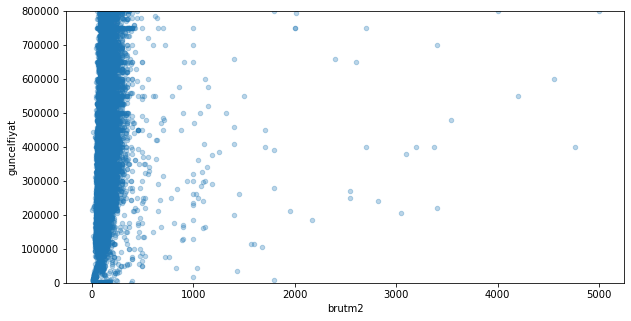

In [22]:
data = pd.concat([train['guncelfiyat'], train['brutm2']], axis=1)
data.plot.scatter(x='brutm2', y='guncelfiyat', alpha=0.3,figsize=(10, 5), ylim=(0,800000));

In [23]:
train.drop(train[(train['netm2']>1500)].index, inplace=True)

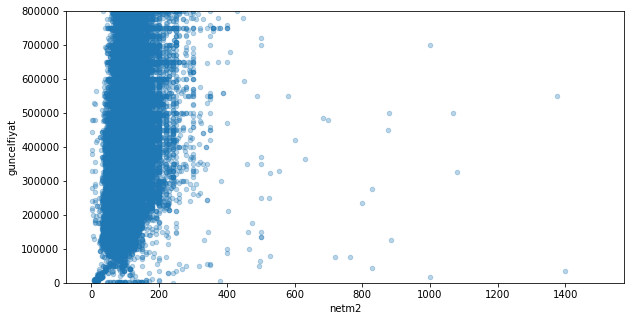

In [24]:
data = pd.concat([train['guncelfiyat'], train['netm2']], axis=1)
data.plot.scatter(x='netm2', y='guncelfiyat', alpha=0.3,figsize=(10, 5), ylim=(0,800000));

In [25]:
train.drop(train[(train['brutm2']<50)].index, inplace=True)

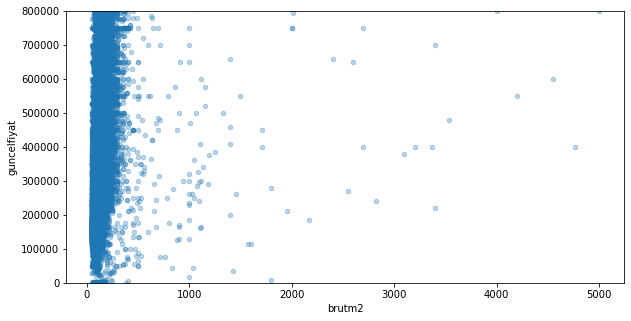

In [26]:
data = pd.concat([train['guncelfiyat'], train['brutm2']], axis=1)
data.plot.scatter(x='brutm2', y='guncelfiyat', alpha=0.3,figsize=(10, 5), ylim=(0,800000));

In [27]:
train.drop(train[(train['netm2']<50)].index, inplace=True)

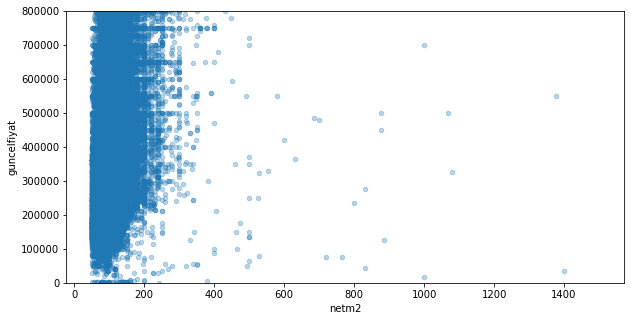

In [28]:
data = pd.concat([train['guncelfiyat'], train['netm2']], axis=1)
data.plot.scatter(x='netm2', y='guncelfiyat', alpha=0.3,figsize=(10, 5), ylim=(0,800000));


Test verisetimde guncelfiyat özniteliğim olmadığı için aynı işlemleri test verisetim için gerçekleştirmiyorum.

Ardından, brüt ve net metrekareler arasında brütün netten büyük olması gerektiğini bildiğim için, bir karışıklıkla karşılaşmamak adına yeni bir öznitelik oluşturup, bu özniteliğe brüt veya netten maksimum olanını yazdıracağım.

In [29]:
features = ["brutm2","netm2"]
train["m2"] = train[features].max(axis = 1)
test["m2"] = test[features].max(axis = 1)

In [30]:
train.head(3)

,tarih,konum,guncelfiyat,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,m2
0,2019-01-01,İstanbul/Beylikdüzü/Adnan Kahveci,1050000,5+2,380.000,370.000,Daire,16-20 arası,12,10-20 arası,Kombi (Doğalgaz),3,"Cadde,Deniz,Göl","Var (Ücretsiz, Kapalı)",VAR,VAR,VAR,VAR,VAR,VAR,1,380.000
1,2019-01-01,İstanbul/Kadıköy/Erenköy,547500,2+1,65.000,55.000,Daire,0,1,7,Kombi (Doğalgaz),1,_,-,VAR,YOK,VAR,YOK,YOK,YOK,11,65.000
2,2019-01-01,İstanbul/Beylikdüzü/Adnan Kahveci,440000,3+1,205.000,197.000,Daire,11-15 arası,2,10-20 arası,Kombi (Doğalgaz),2,"Cadde,Şehir","Var (Ücretsiz, Kapalı)",VAR,VAR,VAR,YOK,YOK,VAR,10,205.000


In [31]:
test.head(3)

,tarih,konum,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,guncelfiyat,m2
0,2020-04-20,İzmir/Konak/Güzelyalı,4+1,165.000,155.000,Daire,31-35 arası,6,7,Kombi (Doğalgaz),1,_,-,YOK,YOK,YOK,YOK,VAR,YOK,64650,NaN,165.000
1,2020-04-20,İzmir/Ödemiş/İnönü,2+1,130.000,120.000,Daire,6-10 arası,2,2,Klima,1,_,-,YOK,YOK,YOK,YOK,YOK,YOK,64651,NaN,130.000
2,2020-04-20,İzmir/Karşıyaka/Örnekköy,3+1,182.000,153.000,Daire,0,7,10-20 arası,Yerden Isıtma,2,_,-,YOK,YOK,YOK,YOK,YOK,YOK,64652,NaN,182.000


Şimdi, train setimde gözüme güncel fiyatta minimum değerin 172 TRY olması çarptı. Bunu da düzenleyelim.

In [32]:
train.drop(train[(train['guncelfiyat']<40000)].index, inplace=True)

In [33]:
train.isna().sum()

tarih             0
konum             0
guncelfiyat       0
odasayisi         0
brutm2            0
netm2             0
emlaktipi         0
binayasi          0
bulundugukat      0
toplamkat         0
isitma            0
banyosayisi       0
manzara           0
otopark           0
interkom          0
depremyonuyg      0
asansor           0
oyunalani         0
giyinmeodasi      0
ebeveynbanyosu    0
id                0
m2                0
dtype: int64

In [34]:
test.isna().sum()

tarih                 0
konum                 0
odasayisi             0
brutm2                0
netm2                 0
emlaktipi             0
binayasi              0
bulundugukat          0
toplamkat             0
isitma                0
banyosayisi           0
manzara               0
otopark               0
interkom              0
depremyonuyg          0
asansor               0
oyunalani             0
giyinmeodasi          0
ebeveynbanyosu        0
id                    0
guncelfiyat       35127
m2                    0
dtype: int64

# ONE HOT ENCODING

Şimdi, verisetimdeki bazı öznitelikleri object özellikten kurtarıp one hot encoding yaparak integer hale getireceğim. Bunu yaparken, özniteliklerim içlerinde null değer varmış gibi davrandı ve one hot encoding'e cevap vermedi. Kontrol ettiğimde null değer olmadığını onaylasam da, sorunun üstesinden gelebilmek için bu özniteliklerimi öncelikle string'e çevirdim.

In [35]:
train['interkom'] = train['interkom'].map(str)
train['depremyonuyg'] = train['depremyonuyg'].map(str)
train['asansor'] = train['asansor'].map(str)
train['oyunalani'] = train['oyunalani'].map(str)
train['giyinmeodasi'] = train['giyinmeodasi'].map(str)
train['ebeveynbanyosu'] = train['ebeveynbanyosu'].map(str)

In [36]:
train.loc[train["interkom"] == "VAR" , "interkom"] = "1"
train.loc[train["interkom"] == "YOK" , "interkom"] = "0"
train["interkom"] = train["interkom"].astype(int)

train.loc[train["depremyonuyg"] == "VAR" , "depremyonuyg"] = "1"
train.loc[train["depremyonuyg"] == "YOK" , "depremyonuyg"] = "0"
train["depremyonuyg"] = train["depremyonuyg"].astype(int)

train.loc[train["asansor"] == "VAR" , "asansor"] = "1"
train.loc[train["asansor"] == "YOK" , "asansor"] = "0"
train["asansor"] = train["asansor"].astype(int)

train.loc[train["oyunalani"] == "VAR" , "oyunalani"] = "1"
train.loc[train["oyunalani"] == "YOK" , "oyunalani"] = "0"
train["oyunalani"] = train["oyunalani"].astype(int)

train.loc[train["giyinmeodasi"] == "VAR" , "giyinmeodasi"] = "1"
train.loc[train["giyinmeodasi"] == "YOK" , "giyinmeodasi"] = "0"
train["giyinmeodasi"] = train["giyinmeodasi"].astype(int)

train.loc[train["ebeveynbanyosu"] == "VAR" , "ebeveynbanyosu"] = "1"
train.loc[train["ebeveynbanyosu"] == "YOK" , "ebeveynbanyosu"] = "0"
train["ebeveynbanyosu"] = train["ebeveynbanyosu"].astype(int)

train.head(10)

,tarih,konum,guncelfiyat,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,m2
0,2019-01-01,İstanbul/Beylikdüzü/Adnan Kahveci,1050000,5+2,380.000,370.000,Daire,16-20 arası,12,10-20 arası,Kombi (Doğalgaz),3,"Cadde,Deniz,Göl","Var (Ücretsiz, Kapalı)",1,1,1,1,1,1,1,380.000
1,2019-01-01,İstanbul/Kadıköy/Erenköy,547500,2+1,65.000,55.000,Daire,0,1,7,Kombi (Doğalgaz),1,_,-,1,0,1,0,0,0,11,65.000
2,2019-01-01,İstanbul/Beylikdüzü/Adnan Kahveci,440000,3+1,205.000,197.000,Daire,11-15 arası,2,10-20 arası,Kombi (Doğalgaz),2,"Cadde,Şehir","Var (Ücretsiz, Kapalı)",1,1,1,0,0,1,10,205.000
3,2019-01-01,İstanbul/Beşiktaş/Nisbetiye,1450000,3+1,150.000,130.000,Daire,26-30 arası,3,5,Merkezi Sistem (Isı Payı Ölçer),2,"Cadde,Şehir","Var (Ücretsiz, Açık)",0,0,1,0,0,1,8,150.000
4,2019-01-01,İstanbul/Beylikdüzü/Cumhuriyet,169000,2+1,70.000,65.000,Daire,1,Kot 1,6,Kombi (Doğalgaz),1,"Boğaz,Deniz,Göl,Doğa",Var,1,0,1,0,1,1,7,70.000
5,2019-01-01,İstanbul/Beylikdüzü/Cumhuriyet,180000,2+1,110.000,95.000,Daire,0,2,6,Kombi (Doğalgaz),1,Şehir,Yok,0,1,1,1,0,0,9,110.000
6,2019-01-01,İzmir/Güzelbahçe/Mustafa Kemal Paşa,695000,2+1,123.000,101.000,Daire,0,1,2,Kat Kaloriferi,1,_,"Var (Ücretsiz, Açık)",1,1,0,1,0,0,5,123.000
7,2019-01-01,İzmir/Buca/Güven,290000,3+1,135.000,125.000,Daire,16-20 arası,2,5,Kombi (Doğalgaz),1,_,-,0,0,0,0,0,0,4,135.000
8,2019-01-01,İzmir/Karşıyaka/Örnekköy,349000,3+1,130.000,115.000,Daire,2,2,3,Kombi (Doğalgaz),1,_,-,0,0,0,0,0,0,3,130.000
10,2019-01-01,İzmir/Menemen/Ulus,210000,3+1,130.000,115.000,Daire,-,4,7,Kombi (Doğalgaz),2,_,Var,1,0,1,1,0,0,6,130.000


Aynı işlemleri test dataseti için de gerçekleştireceğim.

In [37]:
test['interkom'] = test['interkom'].map(str)
test['depremyonuyg'] = test['depremyonuyg'].map(str)
test['asansor'] = test['asansor'].map(str)
test['oyunalani'] = test['oyunalani'].map(str)
test['giyinmeodasi'] = test['giyinmeodasi'].map(str)
test['ebeveynbanyosu'] = test['ebeveynbanyosu'].map(str)

In [38]:
test.loc[test["interkom"] == "VAR" , "interkom"] = "1"
test.loc[test["interkom"] == "YOK" , "interkom"] = "0"
test["interkom"] = test["interkom"].astype(int)

test.loc[test["depremyonuyg"] == "VAR" , "depremyonuyg"] = "1"
test.loc[test["depremyonuyg"] == "YOK" , "depremyonuyg"] = "0"
test["depremyonuyg"] = test["depremyonuyg"].astype(int)

test.loc[test["asansor"] == "VAR" , "asansor"] = "1"
test.loc[test["asansor"] == "YOK" , "asansor"] = "0"
test["asansor"] = test["asansor"].astype(int)

test.loc[test["oyunalani"] == "VAR" , "oyunalani"] = "1"
test.loc[test["oyunalani"] == "YOK" , "oyunalani"] = "0"
test["oyunalani"] = test["oyunalani"].astype(int)

test.loc[test["giyinmeodasi"] == "VAR" , "giyinmeodasi"] = "1"
test.loc[test["giyinmeodasi"] == "YOK" , "giyinmeodasi"] = "0"
test["giyinmeodasi"] = test["giyinmeodasi"].astype(int)

test.loc[test["ebeveynbanyosu"] == "VAR" , "ebeveynbanyosu"] = "1"
test.loc[test["ebeveynbanyosu"] == "YOK" , "ebeveynbanyosu"] = "0"
test["ebeveynbanyosu"] = test["ebeveynbanyosu"].astype(int)

test.head(10)

,tarih,konum,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,guncelfiyat,m2
0,2020-04-20,İzmir/Konak/Güzelyalı,4+1,165.000,155.000,Daire,31-35 arası,6,7,Kombi (Doğalgaz),1,_,-,0,0,0,0,1,0,64650,NaN,165.000
1,2020-04-20,İzmir/Ödemiş/İnönü,2+1,130.000,120.000,Daire,6-10 arası,2,2,Klima,1,_,-,0,0,0,0,0,0,64651,NaN,130.000
2,2020-04-20,İzmir/Karşıyaka/Örnekköy,3+1,182.000,153.000,Daire,0,7,10-20 arası,Yerden Isıtma,2,_,-,0,0,0,0,0,0,64652,NaN,182.000
3,2020-04-20,İzmir/Ödemiş/İnönü,2+1,130.000,120.000,Daire,6-10 arası,2,2,Klima,1,_,-,0,0,0,0,0,0,64653,NaN,130.000
4,2020-04-20,İstanbul/Beylikdüzü/Kavaklı,3+1,125.000,120.000,Daire,0,6,6,Kombi (Doğalgaz),1,"Boğaz,Cadde,Dağ,Deniz,Doğa,Göl",-,1,1,1,1,1,1,64654,NaN,125.000
5,2020-04-20,İstanbul/Kadıköy/Suadiye,2+1,100.000,80.000,Daire,0,2,4,Klima,1,"Doğa,Şehir",-,1,0,1,0,0,0,64658,NaN,100.000
6,2020-04-20,İstanbul/Beylikdüzü/Beylikdüzü OSB,3+1,155.000,145.000,Daire,1,3,6,Kombi (Doğalgaz),2,"Cadde,Doğa,Park,Şehir,Yeşil Alan",-,1,1,1,1,1,1,64656,NaN,155.000
7,2020-04-20,İstanbul/Kadıköy/Suadiye,3+1,179.000,155.000,Daire,31-35 arası,4,4,Merkezi Sistem,2,_,-,1,0,0,0,0,0,64657,NaN,179.000
8,2020-04-20,İzmir/Menemen/Villakent,5+2,1350.000,400.000,Villa,6-10 arası,3,3,Kombi (Doğalgaz),3,_,-,0,0,0,0,0,0,64649,NaN,1350.000
9,2020-04-20,İstanbul/Beylikdüzü/Cumhuriyet,3+1,130.000,120.000,Daire,0,2,5,Kombi (Doğalgaz),2,"Boğaz,Deniz,Doğa,Göl,Şehir",Var,1,0,1,0,1,1,64659,NaN,130.000


Ardından, konum özniteliğindeki / ile ayrılmış il/ilçe/mahalle özniteliklerini ayrı kolonlara ayırıp dataframe'e ekleyeceğim. Boş kalan değerleri 'Merkez' ile doldurmayı tercih ettim.

In [39]:
train[['Il','Ilce','Mahalle']] = train.konum.str.split("/", expand=True)
train = train.drop('konum', 1)
train.fillna("Merkez" , inplace=True)

In [40]:
train.head(3)

,tarih,guncelfiyat,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,m2,Il,Ilce,Mahalle
0,2019-01-01,1050000,5+2,380.000,370.000,Daire,16-20 arası,12,10-20 arası,Kombi (Doğalgaz),3,"Cadde,Deniz,Göl","Var (Ücretsiz, Kapalı)",1,1,1,1,1,1,1,380.000,İstanbul,Beylikdüzü,Adnan Kahveci
1,2019-01-01,547500,2+1,65.000,55.000,Daire,0,1,7,Kombi (Doğalgaz),1,_,-,1,0,1,0,0,0,11,65.000,İstanbul,Kadıköy,Erenköy
2,2019-01-01,440000,3+1,205.000,197.000,Daire,11-15 arası,2,10-20 arası,Kombi (Doğalgaz),2,"Cadde,Şehir","Var (Ücretsiz, Kapalı)",1,1,1,0,0,1,10,205.000,İstanbul,Beylikdüzü,Adnan Kahveci


In [41]:
test[['Il','Ilce','Mahalle']] = test.konum.str.split("/", expand=True)
test = test.drop('konum', 1)

In [42]:
test.head(3)

,tarih,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,guncelfiyat,m2,Il,Ilce,Mahalle
0,2020-04-20,4+1,165.000,155.000,Daire,31-35 arası,6,7,Kombi (Doğalgaz),1,_,-,0,0,0,0,1,0,64650,NaN,165.000,İzmir,Konak,Güzelyalı
1,2020-04-20,2+1,130.000,120.000,Daire,6-10 arası,2,2,Klima,1,_,-,0,0,0,0,0,0,64651,NaN,130.000,İzmir,Ödemiş,İnönü
2,2020-04-20,3+1,182.000,153.000,Daire,0,7,10-20 arası,Yerden Isıtma,2,_,-,0,0,0,0,0,0,64652,NaN,182.000,İzmir,Karşıyaka,Örnekköy


# Manzara Değişkeni

Manzara değişkeni kategorik ve çok fazla birbirinden farklı değer var. Bunları düzenlerken sadece cümlenin başındaki kelimeyi alacağım çünkü belirtilirken en önemli manzara tipi en başa yazılmış (Örneğin boğaz ve dağ manzaralı olan bir konut için önce boğaz manzarası yazılmış).

In [43]:
train.manzara.value_counts()

_                                                                        40359
Şehir                                                                     7492
Doğa,Şehir                                                                2053
Cadde,Şehir                                                               1011
Boğaz,Cadde,Deniz,Havuz,Park,Şehir,Yeşil Alan,Göl,Nehir,Vadi,Dağ,Doğa      960
                                                                         ...  
Deniz,Yeşil Alan,Vadi,Havuz,Doğa,Park                                        1
Deniz,Yeşil Alan,Havuz,Doğa,Park                                             1
Cadde,Park,Şehir,Yeşil Alan,Göl,Nehir                                        1
Göl,Dağ                                                                      1
Yeşil Alan,Boğaz,Deniz,Park,Şehir                                            1
Name: manzara, Length: 913, dtype: int64

Şu an gözüken en uzun betimleme "Boğaz,Cadde,Deniz,Havuz,Park,Şehir,Yeşil Alan,Göl,Nehir,Vadi,Dağ,Doğa" ve bu betimlemede 12 adet nitelik var. Buna göre, ilk manzara tipini alıp diğerlerini drop edeceğim.

In [44]:
b = train.manzara.str.split("," , expand = True)
b.columns = ["a","b","c","d","e","f","g","h","j","k","l","m"] #yukarıda bahsettiğim 12 adet nitelik için 12 harf atadım.
b.drop(["b","c","d","e","f","g","h","j","k","l","m"], axis = 1 , inplace = True)
b.columns = ["manzarasekli"]
b.loc[b["manzarasekli"] == "_" , "manzarasekli"] = "Yok"
train = (pd.merge(train, b, how = "left", left_index = True , right_index = True)).reset_index()

In [45]:
a = test.manzara.str.split("," , expand = True)
a.columns = ["a","b","c","d","e","f","g","h","j","k","l","m"]
a.drop(["b","c","d","e","f","g","h","j","k","l","m"], axis = 1 , inplace = True)
a.columns = ["manzarasekli"]
a.loc[a["manzarasekli"] == "_" , "manzarasekli"] = "Yok"
test = (pd.merge(test, a, how = "left", left_index = True , right_index = True)).reset_index()

In [46]:
test.drop(["index"], axis = 1 , inplace = True)
train.drop(["index"], axis = 1 , inplace = True)

In [47]:
color = ['#FF4040','#EE3B3B','#CD3333','#8B2323','#8A3324',
         '#7FFF00','#66CD00','#458B00','#3D9140','#00EEEE',
         '#00CDCD','#008B8B','#A2CD5A']

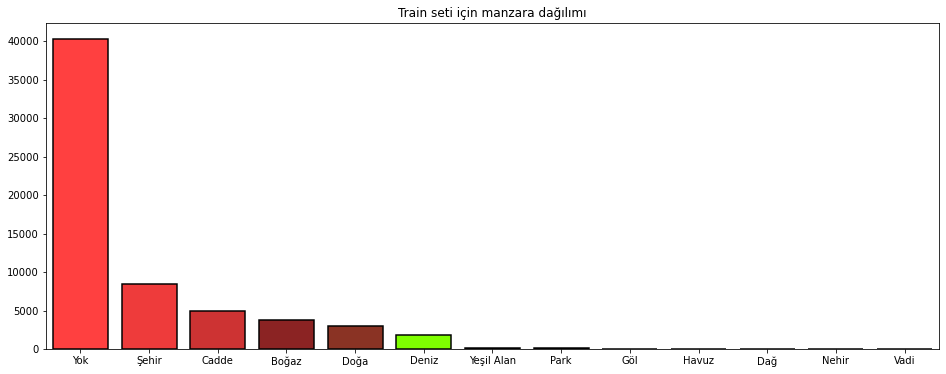

In [48]:
fig = plt.subplots(figsize = (16,6))

sns.barplot(x = train["manzarasekli"].value_counts().index, y = train["manzarasekli"].value_counts().values, palette = color,
           edgecolor = "black", linewidth = 1.5, saturation = 1.5)
plt.title("Train seti için manzara dağılımı");

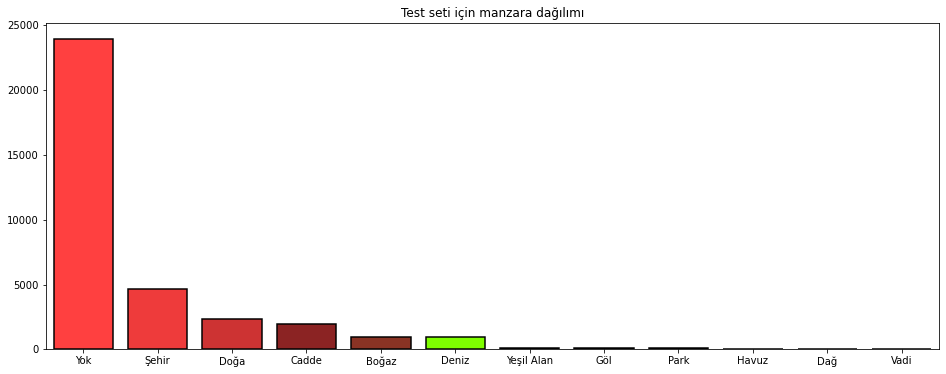

In [49]:
fig = plt.subplots(figsize = (16,6))

sns.barplot(x = test["manzarasekli"].value_counts().index, y = test["manzarasekli"].value_counts().values, palette = color,
           edgecolor = "black", linewidth = 1.5, saturation = 1.5)
plt.title("Test seti için manzara dağılımı");

Veriyi Biraz Daha Temizleyelim

Şimdi, İstanbul ve İzmir illerinin ilçe haritasını yükleyeceğim ve buna göre bazı çıkarımlarda bulunacağım. Örneğin, aşağıda da görüldüğü üzere, Beylikdüzünde boğaz manzaralı bir ev olabilir mi? Ya da İzmir Ödemişte deniz manzaralı bir ev olabilir mi?

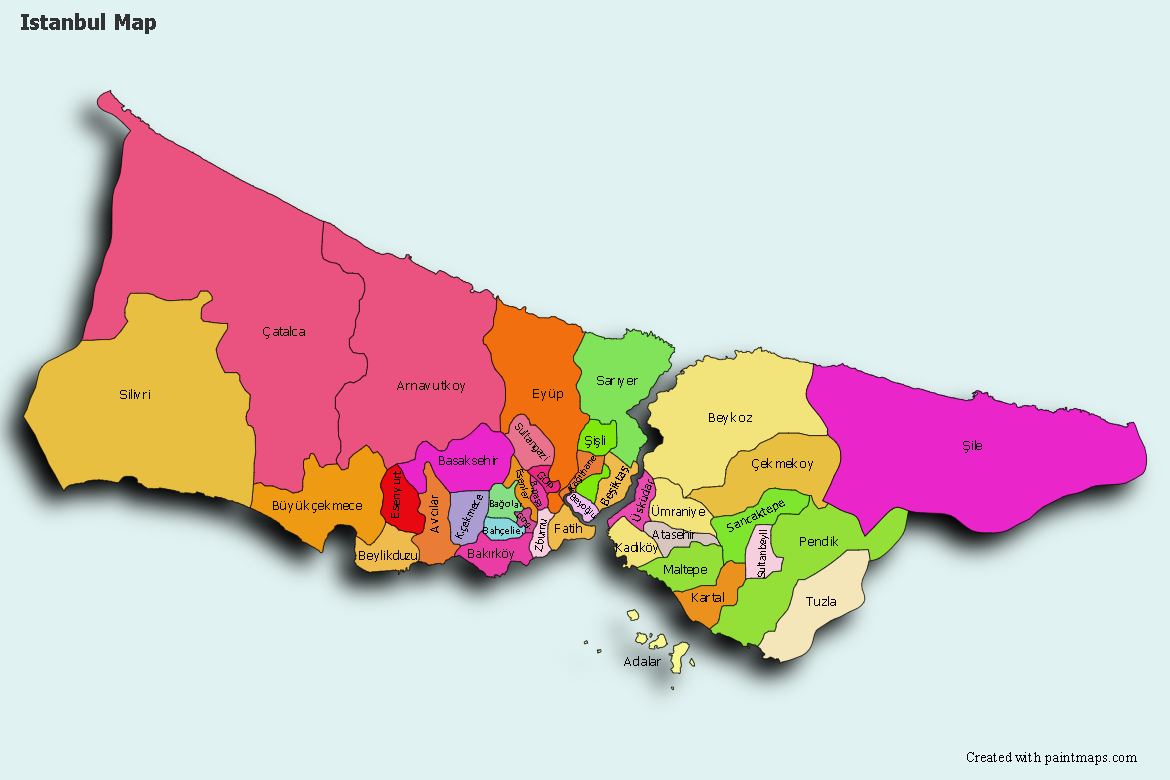

In [50]:
from IPython.display import Image
Image("https://paintmaps.com/og_image/map_chart/map_chart_40c.png")

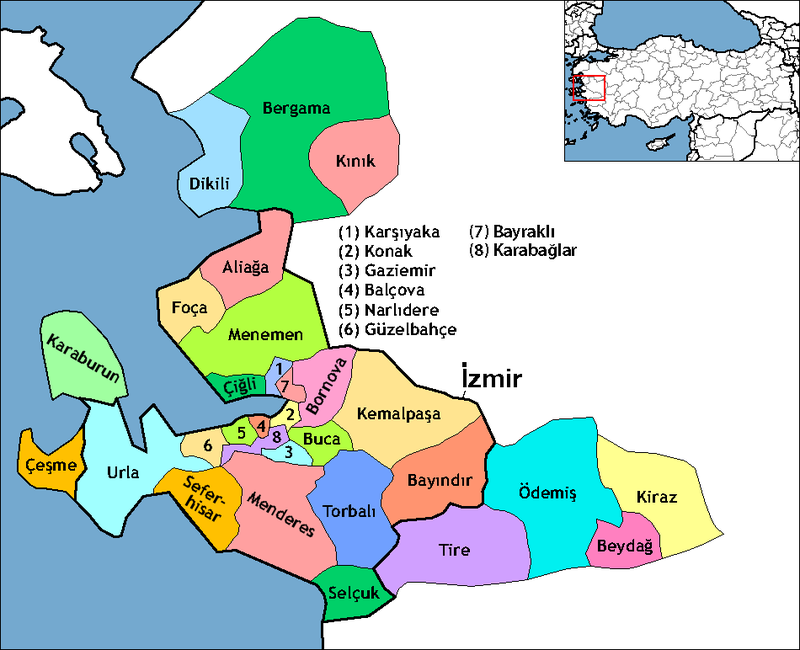

In [51]:
Image("https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/%C4%B0zmir_districts.png/800px-%C4%B0zmir_districts.png")

In [52]:
train.Ilce.value_counts()

Beylikdüzü     14443
Kadıköy         8422
Pendik          4680
Karşıyaka       4251
Bağcılar        2909
Buca            2556
Karabağlar      2395
Beşiktaş        2243
Seferihisar     2212
Torbalı         2066
Çeşme           1888
Konak           1627
Bornova         1266
Çiğli           1228
Urla            1198
Menemen         1096
Menderes        1023
Bayraklı         937
Gaziemir         934
Balçova          925
Güzelbahçe       788
Ödemiş           694
Narlıdere        666
Dikili           617
Bergama          356
Kemalpaşa        336
Tire             324
Selçuk           254
Foça             248
Karaburun        208
Aliağa           102
Bayındır          28
Kınık              5
Merkez             4
Beydağ             1
Name: Ilce, dtype: int64

In [53]:
train[(train.Ilce == "Beylikdüzü") & (train.manzarasekli == "Boğaz")]

,tarih,guncelfiyat,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,m2,Il,Ilce,Mahalle,manzarasekli
4,2019-01-01,169000,2+1,70.000,65.000,Daire,1,Kot 1,6,Kombi (Doğalgaz),1,"Boğaz,Deniz,Göl,Doğa",Var,1,0,1,0,1,1,7,70.000,İstanbul,Beylikdüzü,Cumhuriyet,Boğaz
20,2019-01-02,107700,1+1,70.000,60.000,Daire,0,Bahçe katı,5,Klima,1,"Boğaz,Doğa,Şehir",Var,1,0,1,0,0,1,94,70.000,İstanbul,Beylikdüzü,Cumhuriyet,Boğaz
33,2019-01-02,189500,2+1,100.000,90.000,Daire,0,2,5,Klima,1,"Boğaz,Cadde,Doğa,Park,Şehir,Yeşil Alan",-,1,0,1,0,0,1,82,100.000,İstanbul,Beylikdüzü,Cumhuriyet,Boğaz
51,2019-01-02,170000,2+1,130.000,110.000,Daire,0,2,10,Kombi (Doğalgaz),1,"Boğaz,Deniz,Şehir,Göl,Doğa",Var,1,0,1,0,1,1,131,130.000,İstanbul,Beylikdüzü,Barış,Boğaz
138,2019-01-03,199000,3+1,135.000,130.000,Daire,0,3,5,Kombi (Doğalgaz),1,"Boğaz,Cadde,Yeşil Alan,Göl,Nehir,Vadi,Dağ",-,1,1,1,1,1,1,279,135.000,İstanbul,Beylikdüzü,Cumhuriyet,Boğaz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62854,2020-04-17,150000,3+1,130.000,125.000,Daire,0,Kot 1,5,Kombi (Doğalgaz),2,"Boğaz,Deniz,Doğa,Göl,Şehir",Var,1,0,1,0,1,1,64525,130.000,İstanbul,Beylikdüzü,Cumhuriyet,Boğaz
62879,2020-04-17,134000,2+1,105.000,80.000,Daire,0,2,10,Kombi (Doğalgaz),1,"Boğaz,Cadde,Dağ,Deniz,Doğa,Göl,Havuz,Nehir,Par...",Var,1,1,1,1,1,1,64483,105.000,İstanbul,Beylikdüzü,Cumhuriyet,Boğaz
62890,2020-04-17,165000,3+1,125.000,105.000,Daire,0,3,10,Kombi (Doğalgaz),1,"Boğaz,Cadde,Dağ,Deniz,Doğa,Göl,Havuz,Nehir,Par...",Var,1,1,1,1,1,1,64488,125.000,İstanbul,Beylikdüzü,Yakuplu,Boğaz
62891,2020-04-17,139000,2+1,110.000,85.000,Daire,0,2,9,Kombi (Doğalgaz),1,"Boğaz,Cadde,Dağ,Deniz,Doğa,Göl,Havuz,Nehir,Par...",Var,1,1,1,1,1,1,64487,110.000,İstanbul,Beylikdüzü,Cumhuriyet,Boğaz


In [54]:
train[(train.Ilce == "Pendik") & (train.manzarasekli == "Boğaz")]

,tarih,guncelfiyat,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,m2,Il,Ilce,Mahalle,manzarasekli
1304,2019-01-11,670000,3+1,108.000,92.000,Daire,0,5,10-20 arası,Kombi (Doğalgaz),1,"Boğaz,Cadde,Deniz,Şehir","Var (Açık,Kapalı)",1,1,1,1,0,1,1224,108.000,İstanbul,Pendik,Çınardere,Boğaz
1507,2019-01-14,175000,2+1,100.000,95.000,Daire,3,Yüksek Giriş,5,Kombi (Doğalgaz),1,"Boğaz,Şehir,Göl,Doğa","Var (Ücretsiz, Açık)",1,1,0,0,0,0,1489,100.000,İstanbul,Pendik,Ahmet Yesevi,Boğaz
1608,2019-01-15,360000,3+1,125.000,115.000,Daire,0,5,6,Kombi (Doğalgaz),1,"Boğaz,Şehir,Göl,Doğa","Var (Ücretsiz, Kapalı)",1,1,1,0,0,0,1756,125.000,İstanbul,Pendik,Orhangazi,Boğaz
1613,2019-01-15,360000,3+1,125.000,115.000,Daire,0,5,6,Yerden Isıtma,1,"Boğaz,Doğa,Göl,Şehir","Var (Ücretsiz, Kapalı)",1,0,1,0,0,0,1738,125.000,İstanbul,Pendik,Orhangazi,Boğaz
2099,2019-01-18,190000,3+1,140.000,130.000,Daire,11-15 arası,2,5,Kombi (Doğalgaz),1,"Boğaz,Deniz,Şehir,Göl,Doğa","Var (Ücretsiz, Açık)",1,1,0,0,0,0,2233,140.000,İstanbul,Pendik,Orhangazi,Boğaz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56031,2020-02-29,400000,2+1,120.000,100.000,Daire,0,3,5,Kombi (Doğalgaz),1,"Boğaz,Şehir","Var (Ücretsiz, Kapalı)",1,0,1,0,0,0,57431,120.000,İstanbul,Pendik,Esenler,Boğaz
58018,2020-03-16,209000,2+1,110.000,98.000,Daire,6-10 arası,2,3,Kombi (Doğalgaz),1,"Boğaz,Şehir","Var (Ücretsiz, Kapalı)",0,0,1,0,1,0,59688,110.000,İstanbul,Pendik,Kavakpınar,Boğaz
58178,2020-03-16,418000,3+2,165.000,130.000,Daire,0,4,4,Kombi (Doğalgaz),2,"Boğaz,Şehir","Var (Ücretsiz, Kapalı)",0,0,1,0,1,0,59524,165.000,İstanbul,Pendik,Fevzi Çakmak,Boğaz
62872,2020-04-17,1480000,3+1,150.000,120.000,Villa,2,Komple,1,Soba (Doğalgaz),2,"Boğaz,Doğa,Şehir","Var (Ücretsiz, Kapalı)",0,0,0,0,0,0,64467,150.000,İstanbul,Pendik,Kurna,Boğaz


In [55]:
train[(train.Ilce == "Bağcılar") & (train.manzarasekli == "Boğaz")]

,tarih,guncelfiyat,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,m2,Il,Ilce,Mahalle,manzarasekli
9621,2019-03-18,325000,2+1,110.000,100.000,Daire,6-10 arası,Bahçe katı,4,Klima,1,"Boğaz,Deniz,Şehir,Göl,Doğa",Var,1,0,1,0,1,1,9855,110.000,İstanbul,Bağcılar,Kazım Karabekir,Boğaz
9820,2019-03-20,625000,5+1,290.000,250.000,Daire,0,Bahçe katı,4,Klima,2,"Boğaz,Deniz,Şehir,Göl,Doğa",Var,1,0,1,0,1,1,10197,290.000,İstanbul,Bağcılar,Fatih,Boğaz
9867,2019-03-20,360000,4+1,200.000,180.000,Daire,0,4,4,Klima,3,"Boğaz,Deniz,Şehir,Göl,Doğa",Var,1,0,1,0,1,1,10213,200.000,İstanbul,Bağcılar,15 Temmuz,Boğaz
10302,2019-03-23,258000,2+1,90.000,80.000,Daire,6-10 arası,Bahçe katı,4,Klima,1,"Boğaz,Deniz,Şehir,Göl,Doğa",Var,1,0,1,0,1,1,10542,90.000,İstanbul,Bağcılar,15 Temmuz,Boğaz
10653,2019-03-26,425000,3+1,145.000,130.000,Daire,0,Bahçe katı,4,Klima,1,"Boğaz,Deniz,Şehir,Göl,Doğa",Var,1,0,1,0,1,1,10901,145.000,İstanbul,Bağcılar,Fatih,Boğaz
10928,2019-03-28,105000,2+1,113.000,100.000,Daire,16-20 arası,Bahçe katı,4,Klima,1,"Boğaz,Deniz,Şehir,Göl,Doğa",Var,1,0,1,0,1,1,11133,113.000,İstanbul,Bağcılar,Yenimahalle,Boğaz
13524,2019-04-17,330000,2+1,95.000,90.000,Daire,0,Bahçe katı,4,Klima,1,"Boğaz,Deniz,Şehir,Göl,Doğa",Var,1,0,1,0,1,1,13856,95.000,İstanbul,Bağcılar,Sancaktepe,Boğaz
13560,2019-04-17,225000,1+1,70.000,65.000,Daire,0,Bahçe katı,4,Klima,1,"Boğaz,Deniz,Şehir,Göl,Doğa",Var,1,0,1,0,1,1,13907,70.000,İstanbul,Bağcılar,Yavuz Selim,Boğaz
13617,2019-04-18,359000,2+1,100.000,90.000,Daire,0,Bahçe katı,4,Klima,1,"Boğaz,Deniz,Şehir,Göl,Doğa",Var,1,0,1,0,1,1,14131,100.000,İstanbul,Bağcılar,Sancaktepe,Boğaz
14329,2019-04-24,135000,2+1,100.000,90.000,Daire,16-20 arası,Bahçe katı,4,Klima,1,"Boğaz,Deniz,Şehir,Göl,Doğa",Var,1,0,1,0,1,1,14705,100.000,İstanbul,Bağcılar,Yavuz Selim,Boğaz


İstanbul ili için bu ilçelerdeki boğaz manzaralı gözüken verileri drop edeceğim. Ardından İzmir iline geçeceğim.

In [56]:
train = train.drop(train[(train.manzarasekli == "Boğaz") & (train.Ilce == "Beylikdüzü")].index)
train = train.drop(train[(train.manzarasekli == "Boğaz") & (train.Ilce == "Pendik")].index)
train = train.drop(train[(train.manzarasekli == "Boğaz") & (train.Ilce == "Bağcılar")].index)

In [57]:
train[(train.Ilce == "Bağcılar") & (train.manzarasekli == "Boğaz")]

,tarih,guncelfiyat,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,m2,Il,Ilce,Mahalle,manzarasekli


Kontrol ettiğimde boş olduğunu onaylıyorum, doğru bir şekilde drop edebilmişiz.

In [58]:
test[(test.Ilce == "Torbalı") & (test.manzarasekli == "Deniz")]

,tarih,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,guncelfiyat,m2,Il,Ilce,Mahalle,manzarasekli


In [59]:
train[(train.Ilce == "Ödemiş") & (train.manzarasekli == "Deniz")]

,tarih,guncelfiyat,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,m2,Il,Ilce,Mahalle,manzarasekli


Hem train hem test verisetim için gözüme batan ilçeleri tek tek inceledim ancak buraya kalabalıklaşmaması adına eklemeyeceğim. Hiçbir aykırı değer yok dolayısıyla drop etmeme gerek yok. Metrekare özniteliğini incelemiş ve belli bir aralığa çekmiştik. Şimdi bunları oda sayısı bazında aykırı olabilecekleri drop edelim.

In [60]:
train = train.drop(train[(train.m2 >150) & (train.odasayisi == "1+1")].index)
train = train.drop(train[(train.m2 > 1000) & (train.emlaktipi == "Daire")].index)
train = train.drop(train[(train.m2 < 200) & (train.emlaktipi == "Köşk / Konak / Yalı")].index)

In [61]:
train.guncelfiyat = train.guncelfiyat.astype(int)
train.shape

(59982, 25)

Şimdi train ve test datasetlerimi birleştirip devam edeceğim.

In [62]:
df = pd.concat((train,test)).reset_index(drop = True)
df.tail(10)

,tarih,guncelfiyat,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,m2,Il,Ilce,Mahalle,manzarasekli
95099,2020-12-31,NaN,7+1,300.000,260.000,Yalı Dairesi,-,-,2,Klima,6 ve üzeri,_,-,0,0,0,0,0,1,99661,300.000,İzmir,Foça,Atatürk,Yok
95100,2020-12-31,NaN,3+1,160.000,150.000,Daire,16-20 arası,6,8,Kombi (Doğalgaz),1,_,Var,0,0,1,0,0,0,99662,160.000,İzmir,Karabağlar,Vatan,Yok
95101,2020-12-31,NaN,1+1,56.000,46.000,Daire,1,1,7,Merkezi Sistem (Isı Payı Ölçer),1,_,"Var (Ücretsiz, Kapalı)",1,1,1,0,0,0,99663,56.000,İzmir,Bornova,Kazımdirik,Yok
95102,2020-12-31,NaN,1+1,55.000,45.000,Daire,1,2,7,Merkezi Sistem (Isı Payı Ölçer),1,_,"Var (Ücretsiz, Kapalı)",1,1,1,0,0,0,99664,55.000,İzmir,Bornova,Kazımdirik,Yok
95103,2020-12-31,NaN,3+1,250.000,230.000,Müstakil Ev,21-25 arası,Müstakil,2,Soba (Kömür),1,_,-,0,0,0,0,0,0,99665,250.000,İzmir,Bornova,Rafet Paşa,Yok
95104,2020-12-31,NaN,4+1,200.000,180.000,Villa,11-15 arası,Müstakil,3,Klima,2,_,-,0,0,0,0,0,0,99666,200.000,İzmir,Urla,İçmeler,Yok
95105,2020-12-31,NaN,2+1,85.000,65.000,Daire,21-25 arası,Yüksek Giriş,5,Kombi (Doğalgaz),1,_,-,0,0,0,0,0,0,99667,85.000,İstanbul,Bağcılar,Fevzi Çakmak,Yok
95106,2020-12-31,NaN,3+1,125.000,120.000,Daire,2,2,4,Kombi (Doğalgaz),2,_,-,0,0,1,0,0,0,99668,125.000,İzmir,Seferihisar,Turabiye,Yok
95107,2020-12-31,NaN,7+1,427.000,245.000,Müstakil Ev,40 ve üzeri,Müstakil,2,Soba (Doğalgaz),1,_,Yok,0,0,0,0,0,0,99656,427.000,İzmir,Foça,Fevzipaşa,Yok
95108,2020-12-31,NaN,2+1,85.000,65.000,Daire,21-25 arası,Yüksek Giriş,5,Kombi (Doğalgaz),1,_,-,0,0,0,0,0,0,99700,85.000,İstanbul,Bağcılar,Fevzi Çakmak,Yok


**Tarih Değişkeni**

Tarih özniteliğini gün, ay, yıl olacak şekilde 3 farklı özniteliğe dönüştürelim ve 4. öznitelik olarak yılın kaçıncı haftası olduğu bilgisini ekleyelim.

In [63]:
def date(data) : 
    df["tarih"] = pd.to_datetime(df["tarih"])
    df["Yil"] = df.tarih.dt.year
    df["Ay"] = df.tarih.dt.month
    df["Gun"] = df.tarih.dt.day
    df["YilinHaftasi"] = df.tarih.dt.isocalendar().week

In [64]:
date(df)
df.YilinHaftasi = df.YilinHaftasi.astype(int)
df.head(3)

,tarih,guncelfiyat,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,m2,Il,Ilce,Mahalle,manzarasekli,Yil,Ay,Gun,YilinHaftasi
0,2019-01-01,1050000.000,5+2,380.000,370.000,Daire,16-20 arası,12,10-20 arası,Kombi (Doğalgaz),3,"Cadde,Deniz,Göl","Var (Ücretsiz, Kapalı)",1,1,1,1,1,1,1,380.000,İstanbul,Beylikdüzü,Adnan Kahveci,Cadde,2019,1,1,1
1,2019-01-01,547500.000,2+1,65.000,55.000,Daire,0,1,7,Kombi (Doğalgaz),1,_,-,1,0,1,0,0,0,11,65.000,İstanbul,Kadıköy,Erenköy,Yok,2019,1,1,1
2,2019-01-01,440000.000,3+1,205.000,197.000,Daire,11-15 arası,2,10-20 arası,Kombi (Doğalgaz),2,"Cadde,Şehir","Var (Ücretsiz, Kapalı)",1,1,1,0,0,1,10,205.000,İstanbul,Beylikdüzü,Adnan Kahveci,Cadde,2019,1,1,1


In [65]:
efektifkur = pd.read_csv('Desktop/efektifkur.csv')
efektifkur.head()

,Tarih,Kur
0,01.01.2019,5.298
1,02.01.2019,5.328
2,03.01.2019,5.455
3,04.01.2019,5.405
4,04.01.2019,5.405


In [66]:
efektifkur.isna().sum()

Tarih    0
Kur      0
dtype: int64

In [67]:
b = efektifkur.Tarih.str.split("." , expand = True)
b.columns = ["Gun","Ay","Yil"]
ab = (pd.merge(efektifkur, b, how = "left", left_index = True , right_index = True)).reset_index()
ab.drop(["index","Tarih"], axis = 1 , inplace = True)
ab.Yil = ab.Yil.astype(int)
ab.Ay = ab.Ay.astype(int)
ab.Gun = ab.Gun.astype(int)
ab.Kur = ab.Kur.astype(float)

In [68]:
df = (pd.merge(df, ab, how = "left", on = ["Yil","Ay","Gun"])).reset_index()
df.drop(["index"], axis = 1 , inplace = True)
df.head()

,tarih,guncelfiyat,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,m2,Il,Ilce,Mahalle,manzarasekli,Yil,Ay,Gun,YilinHaftasi,Kur
0,2019-01-01,1050000.000,5+2,380.000,370.000,Daire,16-20 arası,12,10-20 arası,Kombi (Doğalgaz),3,"Cadde,Deniz,Göl","Var (Ücretsiz, Kapalı)",1,1,1,1,1,1,1,380.000,İstanbul,Beylikdüzü,Adnan Kahveci,Cadde,2019,1,1,1,5.298
1,2019-01-01,547500.000,2+1,65.000,55.000,Daire,0,1,7,Kombi (Doğalgaz),1,_,-,1,0,1,0,0,0,11,65.000,İstanbul,Kadıköy,Erenköy,Yok,2019,1,1,1,5.298
2,2019-01-01,440000.000,3+1,205.000,197.000,Daire,11-15 arası,2,10-20 arası,Kombi (Doğalgaz),2,"Cadde,Şehir","Var (Ücretsiz, Kapalı)",1,1,1,0,0,1,10,205.000,İstanbul,Beylikdüzü,Adnan Kahveci,Cadde,2019,1,1,1,5.298
3,2019-01-01,1450000.000,3+1,150.000,130.000,Daire,26-30 arası,3,5,Merkezi Sistem (Isı Payı Ölçer),2,"Cadde,Şehir","Var (Ücretsiz, Açık)",0,0,1,0,0,1,8,150.000,İstanbul,Beşiktaş,Nisbetiye,Cadde,2019,1,1,1,5.298
4,2019-01-01,180000.000,2+1,110.000,95.000,Daire,0,2,6,Kombi (Doğalgaz),1,Şehir,Yok,0,1,1,1,0,0,9,110.000,İstanbul,Beylikdüzü,Cumhuriyet,Şehir,2019,1,1,1,5.298


**LABEL ENCODING**

Var ve Yok öznitelikleri için 0 ve 1 olacak şekilde one hot encoding yapmıştık. Şimdi, bazı öznitelikler için fiyatı etkileyebilecek değerleri label encoding ile kodlayalım. Örneğin, bulundugukat özniteliği için, Kot değerlerine 0  verirken, üst katlara çıktıkça 3-4 gibi sayısal değerler vereceğim.

In [69]:
df.bulundugukat.value_counts()

2               19665
3               16653
1               12833
4               12050
-                8997
5                7667
Müstakil         7351
Bahçe katı       6712
Yüksek Giriş     6585
6                4171
Giriş Katı       3943
7                3656
8                2882
9                2554
10               1859
Zemin Kat        1363
11               1295
Komple           1289
Kot 1            1007
12                962
13                793
Çatı Katı         736
Kot 2             710
14                593
Kot 3             453
20 ve üzeri       367
Kot 4             305
15                298
16                202
En Üst Kat        185
17                163
Teras Kat          99
Bodrum Kat         93
18                 87
19                 48
Name: bulundugukat, dtype: int64

In [70]:
df.loc[df["bulundugukat"] == "Kot 1" , "bulundugukat"] = "0"
df.loc[df["bulundugukat"] == "Kot 2" , "bulundugukat"] = "0"
df.loc[df["bulundugukat"] == "Kot 3" , "bulundugukat"] = "0"
df.loc[df["bulundugukat"] == "Kot 4" , "bulundugukat"] = "0"
df.loc[df["bulundugukat"] == "Bodrum Kat" , "bulundugukat"] = "0"
df.loc[df["bulundugukat"] == "Yüksek Giriş" , "bulundugukat"] = "0"

df.loc[df["bulundugukat"] == "-" , "bulundugukat"] = "1"
df.loc[df["bulundugukat"] == "1" , "bulundugukat"] = "1"
df.loc[df["bulundugukat"] == "Bahçe katı" , "bulundugukat"] = "1"
df.loc[df["bulundugukat"] == "Zemin Kat" , "bulundugukat"] = "1"
df.loc[df["bulundugukat"] == "Giriş Katı" , "bulundugukat"] = "1"
df.loc[df["bulundugukat"] == "Çatı Katı" , "bulundugukat"] = "1"

df.loc[df["bulundugukat"] == "2" , "bulundugukat"] = "2"
df.loc[df["bulundugukat"] == "3" , "bulundugukat"] = "2"
df.loc[df["bulundugukat"] == "4" , "bulundugukat"] = "2"
df.loc[df["bulundugukat"] == "5" , "bulundugukat"] = "2"
df.loc[df["bulundugukat"] == "Teras Kat" , "bulundugukat"] = "2"
df.loc[df["bulundugukat"] == "En Üst Kat" , "bulundugukat"] = "2"

df.loc[df["bulundugukat"] == "6" , "bulundugukat"] = "3"
df.loc[df["bulundugukat"] == "7" , "bulundugukat"] = "3"
df.loc[df["bulundugukat"] == "8" , "bulundugukat"] = "3"
df.loc[df["bulundugukat"] == "9" , "bulundugukat"] = "3"
df.loc[df["bulundugukat"] == "10" , "bulundugukat"] = "3"

df.loc[df["bulundugukat"] == "11" , "bulundugukat"] = "4"
df.loc[df["bulundugukat"] == "12" , "bulundugukat"] = "4"
df.loc[df["bulundugukat"] == "13" , "bulundugukat"] = "4"
df.loc[df["bulundugukat"] == "14" , "bulundugukat"] = "4"
df.loc[df["bulundugukat"] == "15" , "bulundugukat"] = "4"
df.loc[df["bulundugukat"] == "16" , "bulundugukat"] = "4"
df.loc[df["bulundugukat"] == "17" , "bulundugukat"] = "4"
df.loc[df["bulundugukat"] == "18" , "bulundugukat"] = "4"
df.loc[df["bulundugukat"] == "19" , "bulundugukat"] = "4"
df.loc[df["bulundugukat"] == "20 ve üzeri" , "bulundugukat"] = "4"

df.loc[df["bulundugukat"] == "Müstakil" , "bulundugukat"] = "5"
df.loc[df["bulundugukat"] == "Komple" , "bulundugukat"] = "5"
df.bulundugukat= df.bulundugukat.astype(int)

In [71]:
df.binayasi.value_counts()

0              48034
6-10 arası     12350
16-20 arası     8291
26-30 arası     8060
21-25 arası     7845
11-15 arası     6903
1               6722
2               5983
4               5722
3               5187
31-35 arası     4925
-               4649
5               2543
36-40 arası      842
40 ve üzeri      570
Name: binayasi, dtype: int64

In [72]:
df.loc[df["binayasi"] == "31-35 arası" , "binayasi"] = "0"
df.loc[df["binayasi"] == "36-40 arası" , "binayasi"] = "0"
df.loc[df["binayasi"] == "40 ve üzeri" , "binayasi"] = "0"

df.loc[df["binayasi"] == "16-20 arası" , "binayasi"] = "1"
df.loc[df["binayasi"] == "21-25 arası" , "binayasi"] = "1"
df.loc[df["binayasi"] == "26-30 arası" , "binayasi"] = "1"
df.loc[df["binayasi"] == "-" , "binayasi"] = "1"

df.loc[df["binayasi"] == "6-10 arası" , "binayasi"] = "2"
df.loc[df["binayasi"] == "11-15 arası" , "binayasi"] = "2"

df.loc[df["binayasi"] == "0" , "binayasi"] = "3"
df.loc[df["binayasi"] == "1" , "binayasi"] = "3"
df.loc[df["binayasi"] == "2" , "binayasi"] = "3"
df.loc[df["binayasi"] == "3" , "binayasi"] = "3"
df.loc[df["binayasi"] == "4" , "binayasi"] = "3"
df.loc[df["binayasi"] == "5" , "binayasi"] = "3"
df.binayasi = df.binayasi.astype(int)

In [73]:
df.isitma.value_counts()

Kombi (Doğalgaz)                   71109
Klima                              21848
Merkezi Sistem (Isı Payı Ölçer)    10466
Merkezi Sistem                      5631
-                                   5401
Yok                                 3213
Yerden Isıtma                       2578
Kalorifer (Doğalgaz)                2163
Soba (Kömür)                        1539
Kat Kaloriferi                      1420
Jeotermal                           1213
Kombi (Elektrikli)                   698
Soba (Doğalgaz)                      572
Fancoil                              459
Kalorifer (Kömür)                    133
Güneş Enerjisi                        93
Kalorifer (Akaryakıt)                 90
Name: isitma, dtype: int64

In [74]:
df.loc[df["isitma"] == "Yok" , "isitma"] = "0"
df.loc[df["isitma"] == "Soba (Doğalgaz)" , "isitma"] = "0"
df.loc[df["isitma"] == "Soba (Kömür)" , "isitma"] = "0"

df.loc[df["isitma"] == "Kat Kaloriferi" , "isitma"] = "1"
df.loc[df["isitma"] == "Merkezi Sistem (Isı Payı Ölçer)" , "isitma"] = "1"
df.loc[df["isitma"] == "Kombi (Doğalgaz)" , "isitma"] = "1"
df.loc[df["isitma"] == "Kalorifer (Doğalgaz)" , "isitma"] = "1"
df.loc[df["isitma"] == "Kombi (Elektrikli)" , "isitma"] = "1"
df.loc[df["isitma"] == "Kalorifer (Akaryakıt)" , "isitma"] = "1"
df.loc[df["isitma"] == "Kalorifer (Kömür)" , "isitma"] = "1"
df.loc[df["isitma"] == "-" , "isitma"] = "1"
df.loc[df["isitma"] == "Merkezi Sistem" , "isitma"] = "1"
df.loc[df["isitma"] == "Fancoil" , "isitma"] = "1"

df.loc[df["isitma"] == "Klima" , "isitma"] = "2"
df.loc[df["isitma"] == "Yerden Isıtma" , "isitma"] = "2"
df.loc[df["isitma"] == "Jeotermal" , "isitma"] = "2"
df.loc[df["isitma"] == "Güneş Enerjisi" , "isitma"] = "2"
df.isitma = df.isitma.astype(int)

In [75]:
df.odasayisi.value_counts()

3+1       53102
2+1       44942
4+1       10185
1+1        8640
4+2        2746
5+1        2737
5+2        1766
3+2        1586
6+2         607
6+1         583
2+2         273
1+0         251
7+2         217
7+1         180
-           104
8+2          98
10+0         95
2+0          81
6+3          64
4+3          63
8+1          47
5+3          45
7+3          43
8+3          29
9+2          24
9+1          23
9+3          15
1149+0       15
10+2         14
8+4          14
10+1          9
9+4           8
4+4           7
12+2          4
10+4          3
11+3          3
14+4          1
12+3          1
14+3          1
Name: odasayisi, dtype: int64

In [76]:
df.loc[df["odasayisi"] == "1149+0", "odasayisi"] = "3+1"
df.loc[df["odasayisi"] == "-", "odasayisi"] = "2+1"

In [77]:
df.otopark.value_counts()

-                         69911
Var                       26805
Var (Ücretsiz, Kapalı)    19642
Var (Ücretsiz, Açık)       7994
Var (Açık,Kapalı)          2692
Yok                        1508
Var (Ücretli, Açık)          44
Var (Ücretli, Kapalı)        30
Name: otopark, dtype: int64

In [78]:
df.loc[df["otopark"] == "Yok" , "otopark"] = "0"
df.loc[df["otopark"] == "-" , "otopark"] = "0"

df.loc[df["otopark"] == "Var (Ücretsiz, Kapalı)" , "otopark"] = "1"
df.loc[df["otopark"] == "Var (Ücretsiz, Açık)" , "otopark"] = "1"
df.loc[df["otopark"] == "Var" , "otopark"] = "1"
df.loc[df["otopark"] == "Var (Açık,Kapalı)" , "otopark"] = "1"

df.loc[df["otopark"] == "Var (Ücretli, Kapalı)" , "otopark"] = "2"
df.loc[df["otopark"] == "Var (Ücretli, Açık)" , "otopark"] = "2"
df.otopark = df.otopark.astype(int)

In [79]:
df.banyosayisi.value_counts()

1             69520
2             46610
3              8153
4              2240
-               639
5               630
0               457
6 ve üzeri      377
Name: banyosayisi, dtype: int64

In [80]:
df.loc[df["banyosayisi"] == "0", "banyosayisi"] = "1"
df.loc[df["banyosayisi"] == "-", "banyosayisi"] = "1"
df.loc[df["banyosayisi"] == "6 ve üzeri" , "banyosayisi"] = "6"
df.banyosayisi = df.banyosayisi.astype(int)

In [81]:
df.manzarasekli.value_counts()

Yok           86142
Şehir         18214
Cadde          9440
Doğa           7448
Deniz          3828
Boğaz          2272
Göl             425
Yeşil Alan      360
Park            264
Havuz           159
Dağ              53
Vadi             13
Nehir             8
Name: manzarasekli, dtype: int64

In [82]:
df.loc[df["manzarasekli"] == "Yok", "manzarasekli"] = "0"
df.loc[df["manzarasekli"] == "Park", "manzarasekli"] = "0"
df.loc[df["manzarasekli"] == "Yeşil Alan", "manzarasekli"] = "0"
df.loc[df["manzarasekli"] == "Şehir", "manzarasekli"] = "0"
df.loc[df["manzarasekli"] == "Cadde", "manzarasekli"] = "0"

df.loc[df["manzarasekli"] == "Havuz", "manzarasekli"] = "1"
df.loc[df["manzarasekli"] == "Doğa", "manzarasekli"] = "1"
df.loc[df["manzarasekli"] == "Dağ", "manzarasekli"] = "1"
df.loc[df["manzarasekli"] == "Vadi", "manzarasekli"] = "1"
df.loc[df["manzarasekli"] == "Nehir", "manzarasekli"] = "1"
df.loc[df["manzarasekli"] == "Göl", "manzarasekli"] = "1"
df.loc[df["manzarasekli"] == "Deniz", "manzarasekli"] = "1"

df.loc[df["manzarasekli"] == "Boğaz", "manzarasekli"] = "2"
df.manzarasekli = df.manzarasekli.astype(int)

In [83]:
df.head()

,tarih,guncelfiyat,odasayisi,brutm2,netm2,emlaktipi,binayasi,bulundugukat,toplamkat,isitma,banyosayisi,manzara,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,id,m2,Il,Ilce,Mahalle,manzarasekli,Yil,Ay,Gun,YilinHaftasi,Kur
0,2019-01-01,1050000.000,5+2,380.000,370.000,Daire,3,4,10-20 arası,1,3,"Cadde,Deniz,Göl",1,1,1,1,1,1,1,1,380.000,İstanbul,Beylikdüzü,Adnan Kahveci,0,2019,1,1,1,5.298
1,2019-01-01,547500.000,2+1,65.000,55.000,Daire,3,1,7,1,1,_,0,1,0,1,0,0,0,11,65.000,İstanbul,Kadıköy,Erenköy,0,2019,1,1,1,5.298
2,2019-01-01,440000.000,3+1,205.000,197.000,Daire,3,2,10-20 arası,1,2,"Cadde,Şehir",1,1,1,1,0,0,1,10,205.000,İstanbul,Beylikdüzü,Adnan Kahveci,0,2019,1,1,1,5.298
3,2019-01-01,1450000.000,3+1,150.000,130.000,Daire,3,2,5,1,2,"Cadde,Şehir",1,0,0,1,0,0,1,8,150.000,İstanbul,Beşiktaş,Nisbetiye,0,2019,1,1,1,5.298
4,2019-01-01,180000.000,2+1,110.000,95.000,Daire,3,2,6,1,1,Şehir,0,0,1,1,1,0,0,9,110.000,İstanbul,Beylikdüzü,Cumhuriyet,0,2019,1,1,1,5.298


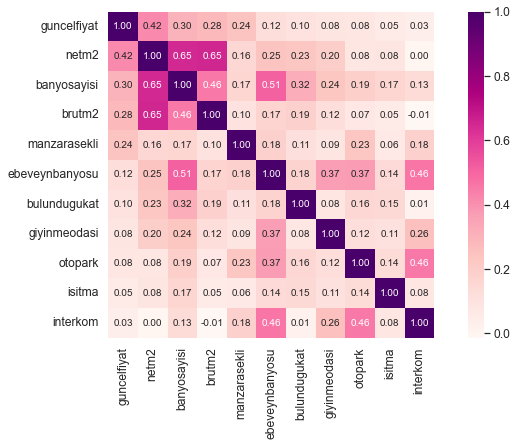

In [84]:
df4matrix = df[:train.shape[0]].drop(["m2"],axis = 1)
corrmatrix = df4matrix.corr()
plt.figure(figsize = (12,6))
columnz = corrmatrix.nlargest(11 , "guncelfiyat")["guncelfiyat"].index
cm = np.corrcoef(df4matrix[columnz].values.T)
sns.set(font_scale = 1.1)
hm = sns.heatmap(cm , cbar = True , annot = True , square = True ,
                cmap = "RdPu" , fmt = ".2f" , annot_kws = {"size" : 10} ,
                 yticklabels = columnz.values , xticklabels = columnz.values)
plt.show()

Değiştirdiğim ve kullanmayacağım değerleri drop edeceğim. Ama ondan önce ml için yardımcı olabilecek iki yeni öznitelik ekleyelim.

In [85]:
df["m2ort"] = (df.brutm2 + df.netm2) / 2

features = ["netm2","binayasi","isitma","otopark","interkom","depremyonuyg","asansor","oyunalani","giyinmeodasi",
           "ebeveynbanyosu","m2","Kur"]

df["axscore"] = df[features].sum(axis = 1)

In [86]:
df = df.drop(["tarih","toplamkat","brutm2","manzara","id"] , axis = 1)
df.head()

,guncelfiyat,odasayisi,netm2,emlaktipi,binayasi,bulundugukat,isitma,banyosayisi,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,m2,Il,Ilce,Mahalle,manzarasekli,Yil,Ay,Gun,YilinHaftasi,Kur,m2ort,axscore
0,1050000.000,5+2,370.000,Daire,3,4,1,3,1,1,1,1,1,1,1,380.000,İstanbul,Beylikdüzü,Adnan Kahveci,0,2019,1,1,1,5.298,375.000,766.298
1,547500.000,2+1,55.000,Daire,3,1,1,1,0,1,0,1,0,0,0,65.000,İstanbul,Kadıköy,Erenköy,0,2019,1,1,1,5.298,60.000,131.298
2,440000.000,3+1,197.000,Daire,3,2,1,2,1,1,1,1,0,0,1,205.000,İstanbul,Beylikdüzü,Adnan Kahveci,0,2019,1,1,1,5.298,201.000,416.298
3,1450000.000,3+1,130.000,Daire,3,2,1,2,1,0,0,1,0,0,1,150.000,İstanbul,Beşiktaş,Nisbetiye,0,2019,1,1,1,5.298,140.000,292.298
4,180000.000,2+1,95.000,Daire,3,2,1,1,0,0,1,1,1,0,0,110.000,İstanbul,Beylikdüzü,Cumhuriyet,0,2019,1,1,1,5.298,102.500,217.298


# Regresyon

In [87]:
df.head()

,guncelfiyat,odasayisi,netm2,emlaktipi,binayasi,bulundugukat,isitma,banyosayisi,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,m2,Il,Ilce,Mahalle,manzarasekli,Yil,Ay,Gun,YilinHaftasi,Kur,m2ort,axscore
0,1050000.000,5+2,370.000,Daire,3,4,1,3,1,1,1,1,1,1,1,380.000,İstanbul,Beylikdüzü,Adnan Kahveci,0,2019,1,1,1,5.298,375.000,766.298
1,547500.000,2+1,55.000,Daire,3,1,1,1,0,1,0,1,0,0,0,65.000,İstanbul,Kadıköy,Erenköy,0,2019,1,1,1,5.298,60.000,131.298
2,440000.000,3+1,197.000,Daire,3,2,1,2,1,1,1,1,0,0,1,205.000,İstanbul,Beylikdüzü,Adnan Kahveci,0,2019,1,1,1,5.298,201.000,416.298
3,1450000.000,3+1,130.000,Daire,3,2,1,2,1,0,0,1,0,0,1,150.000,İstanbul,Beşiktaş,Nisbetiye,0,2019,1,1,1,5.298,140.000,292.298
4,180000.000,2+1,95.000,Daire,3,2,1,1,0,0,1,1,1,0,0,110.000,İstanbul,Beylikdüzü,Cumhuriyet,0,2019,1,1,1,5.298,102.500,217.298


In [88]:
lrdf = df[10:30]

In [89]:
lrdf['banyo_m2'] = lrdf.netm2 * lrdf.banyosayisi
lrdf['kat_manzara'] = lrdf.bulundugukat * lrdf.manzarasekli
lrdf['yas_deprem'] = lrdf.binayasi * lrdf.depremyonuyg

In [90]:
Y = lrdf['guncelfiyat']
X = lrdf[['axscore', 'banyo_m2', 'kat_manzara', 'yas_deprem']]

In [91]:
lrdf.tail()

,guncelfiyat,odasayisi,netm2,emlaktipi,binayasi,bulundugukat,isitma,banyosayisi,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,m2,Il,Ilce,Mahalle,manzarasekli,Yil,Ay,Gun,YilinHaftasi,Kur,m2ort,axscore,banyo_m2,kat_manzara,yas_deprem
25,1250000.000,4+2,240.000,Villa,3,1,1,2,1,0,0,0,0,0,0,280.000,İstanbul,Beylikdüzü,Dereağzı,1,2019,1,2,1,5.328,260.000,530.328,480.000,1,0
26,109000.000,2+1,90.000,Daire,3,1,1,1,0,1,0,1,0,0,0,100.000,İstanbul,Beylikdüzü,Cumhuriyet,0,2019,1,2,1,5.328,95.000,201.328,90.000,0,0
27,1250000.000,4+2,240.000,Villa,3,1,1,2,1,0,0,0,0,0,0,280.000,İstanbul,Beylikdüzü,Dereağzı,1,2019,1,2,1,5.328,260.000,530.328,480.000,1,0
28,118000.000,1+1,65.000,Daire,3,1,1,1,0,1,0,1,0,0,0,80.000,İstanbul,Beylikdüzü,Cumhuriyet,0,2019,1,2,1,5.328,72.500,156.328,65.000,0,0
29,265000.000,1+1,70.000,Daire,3,1,1,1,1,1,0,1,0,0,0,78.000,İstanbul,Beylikdüzü,Adnan Kahveci,1,2019,1,2,1,5.328,74.000,160.328,70.000,1,0


In [92]:
from sklearn import linear_model

lrm = linear_model.LinearRegression()
lrm.fit(X, Y)

LinearRegression()

In [93]:
print('Değişkenler: \n', lrm.coef_)
print('Sabit değer (bias): \n', lrm.intercept_)

Değişkenler: 
 [1.09863272e+03 3.57782662e+02 4.84075833e+05 0.00000000e+00]
Sabit değer (bias): 
 -96400.84588080982


In [94]:
import statsmodels.api as sm

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            guncelfiyat   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     19.36
Date:                Sun, 30 Jan 2022   Prob (F-statistic):           1.42e-05
Time:                        21:28:00   Log-Likelihood:                -270.89
No. Observations:                  20   AIC:                             549.8
Df Residuals:                      16   BIC:                             553.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -9.64e+04   1.65e+05     -0.586      0.566   -4.45e+05    2.53e+05
axscore      1098.6327   1162.654      0.945      0.359   -1366.083    3563.349
banyo_m2      357.7827    892.117      0.401      0.694   -1533.421    2248.987
kat_manzara  4.841e+05   1.35e+05      3.591      0.002    1.98e+05     7.7e+05
yas_deprem           0          0        nan        nan           0           0
==============================================================================
Omnibus:                        3.044   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                1.294
Skew:                           0.266   Prob(JB):                        0.523
Kurtosis:                       4.127   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape[0]))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape[0]))

Eğitim kümesindeki gözlem sayısı : 16
Test kümesindeki gözlem sayısı   : 4


In [96]:
X_train = sm.add_constant(X_train)
sonuclar = sm.OLS(y_train, X_train).fit()
sonuclar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            guncelfiyat   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     18.37
Date:                Sun, 30 Jan 2022   Prob (F-statistic):           8.83e-05
Time:                        21:28:00   Log-Likelihood:                -214.46
No. Observations:                  16   AIC:                             436.9
Df Residuals:                      12   BIC:                             440.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.037e+05   1.91e+05      1.069      0.306   -2.12e+05    6.19e+05
axscore      -578.1552   1231.325     -0.470      0.647   -3260.982    2104.671
banyo_m2     1151.1672    875.341      1.315      0.213    -756.037    3058.371
kat_manzara  8.004e+05   1.85e+05      4.327      0.001    3.97e+05     1.2e+06
yas_deprem           0          0        nan        nan           0           0
==============================================================================
Omnibus:                       29.396   Durbin-Watson:                   2.418
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.161
Skew:                           2.596   Prob(JB):                     9.47e-11
Kurtosis:                       9.502   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

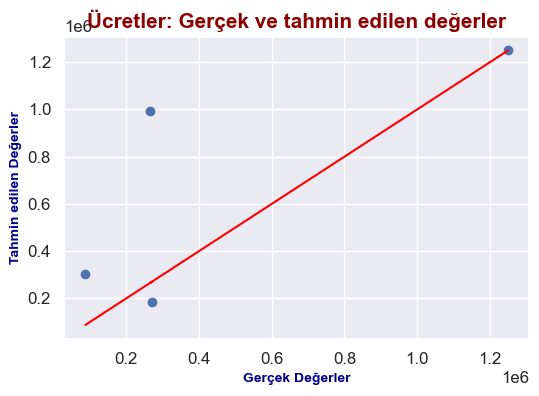

Ortalama Mutlak Hata (MAE)        : 256706.76681832128
Ortalama Kare Hata (MSE)          : 145546462408.78207
Kök Ortalama Kare Hata (RMSE)     : 381505.5208103574
Ortalama Mutlak Yüzde Hata (MAPE) : 138.09916047440515


In [97]:
X_test = sm.add_constant(X_test)

y_preds = sonuclar.predict(X_test)


baslik_font = {'family': 'arial','color':  'darkred','weight': 'bold','size': 15 }
eksen_font = {'family': 'arial','color':  'darkblue','weight': 'bold','size': 10 }
plt.figure(dpi = 100)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Gerçek Değerler", fontdict=eksen_font)
plt.ylabel("Tahmin edilen Değerler", fontdict=eksen_font)
plt.title("Ücretler: Gerçek ve tahmin edilen değerler", fontdict=baslik_font)
plt.show()

from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

print("Ortalama Mutlak Hata (MAE)        : {}".format(mean_absolute_error(y_test, y_preds)))
print("Ortalama Kare Hata (MSE)          : {}".format(mse(y_test, y_preds)))
print("Kök Ortalama Kare Hata (RMSE)     : {}".format(rmse(y_test, y_preds)))
print("Ortalama Mutlak Yüzde Hata (MAPE) : {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Sonuçlar çok kötü.

In [98]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

In [99]:
from sklearn.model_selection import train_test_split
X_eğitim, X_test, y_eğitim, y_test =  train_test_split(X, Y, test_size=0.20, random_state=111)

In [100]:
log_reg.fit(X_eğitim, y_eğitim)

LogisticRegression()

In [101]:
egitim_dogruluk = log_reg.score(X_eğitim, y_eğitim)
test_dogruluk = log_reg.score(X_test, y_test)
print('One-vs-rest', '-'*20, 
      'Modelin eğitim verisindeki doğruluğu : {:.2f}'.format(egitim_dogruluk), 
      'Modelin test verisindeki doğruluğu   : {:.2f}'.format(test_dogruluk), sep='\n')

One-vs-rest
--------------------
Modelin eğitim verisindeki doğruluğu : 0.44
Modelin test verisindeki doğruluğu   : 0.25


# MAKİNE ÖĞRENMESİ


**XGBoost**

In [102]:
df = pd.get_dummies(df , columns = ["odasayisi","emlaktipi","Il","Ilce","Mahalle"])

In [103]:
df.head()

,guncelfiyat,netm2,binayasi,bulundugukat,isitma,banyosayisi,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,m2,manzarasekli,Yil,Ay,Gun,YilinHaftasi,Kur,m2ort,axscore,odasayisi_1+0,odasayisi_1+1,odasayisi_10+0,odasayisi_10+1,odasayisi_10+2,odasayisi_10+4,odasayisi_11+3,odasayisi_12+2,odasayisi_12+3,odasayisi_14+3,odasayisi_14+4,odasayisi_2+0,odasayisi_2+1,odasayisi_2+2,odasayisi_3+1,odasayisi_3+2,odasayisi_4+1,odasayisi_4+2,odasayisi_4+3,odasayisi_4+4,odasayisi_5+1,odasayisi_5+2,odasayisi_5+3,odasayisi_6+1,odasayisi_6+2,odasayisi_6+3,odasayisi_7+1,odasayisi_7+2,odasayisi_7+3,odasayisi_8+1,odasayisi_8+2,odasayisi_8+3,odasayisi_8+4,odasayisi_9+1,odasayisi_9+2,odasayisi_9+3,odasayisi_9+4,emlaktipi_Daire,emlaktipi_Köşk / Konak / Yalı,emlaktipi_Müstakil Ev,emlaktipi_Prefabrik Ev,emlaktipi_Rezidans,emlaktipi_Villa,emlaktipi_Yalı Dairesi,emlaktipi_Yazlık,emlaktipi_Çiftlik Evi,Il_İstanbul,Il_İzmir,Ilce_Aliağa,Ilce_Balçova,Ilce_Bayraklı,Ilce_Bayındır,Ilce_Bağcılar,Ilce_Bergama,Ilce_Beydağ,Ilce_Beylikdüzü,Ilce_Beşiktaş,Ilce_Bornova,Ilce_Buca,Ilce_Dikili,Ilce_Foça,Ilce_Gaziemir,Ilce_Güzelbahçe,Ilce_Kadıköy,Ilce_Karabağlar,Ilce_Karaburun,Ilce_Karşıyaka,Ilce_Kemalpaşa,Ilce_Kiraz,Ilce_Konak,Ilce_Kınık,Ilce_Menderes,Ilce_Menemen,Ilce_Merkez,Ilce_Narlıdere,Ilce_Pendik,Ilce_Seferihisar,Ilce_Selçuk,Ilce_Tire,Ilce_Torbalı,Ilce_Urla,Ilce_Çeşme,Ilce_Çiğli,Ilce_Ödemiş,Mahalle_1. Kadriye,Mahalle_100. Yıl,Mahalle_14 Mayıs,Mahalle_15 Temmuz,Mahalle_16 Eylül,Mahalle_19 Mayıs,Mahalle_2. Kadriye,Mahalle_2. İnönü,Mahalle_26 Ağustos,Mahalle_29 Ekim,Mahalle_30 Ağustos,Mahalle_4 Eylül,Mahalle_75. Yıl,Mahalle_75. Yıl Cumhuriyet,Mahalle_85. Yıl Cumhuriyet,Mahalle_9 Eylül,Mahalle_Abbasağa,Mahalle_Abdi İpekçi,Mahalle_Acıbadem,Mahalle_Adalet,Mahalle_Adatepe,Mahalle_Adnan Kahveci,Mahalle_Adnan Menderes,Mahalle_Adnan Süvari,Mahalle_Ahmet Efendi,Mahalle_Ahmet Taner Kışlalı,Mahalle_Ahmet Yesevi,Mahalle_Ahmetbeyli,Mahalle_Ahıhıdır,Mahalle_Akat,Mahalle_Akdeniz,Mahalle_Aksoy,Mahalle_Aktepe,Mahalle_Akçaköy,Mahalle_Akın Simav,Mahalle_Akıncı,Mahalle_Akıncılar,Mahalle_Alaniçi,Mahalle_Alankıyı,Mahalle_Alaybey,Mahalle_Alaçatı,Mahalle_Ali Fuat Cebesoy,Mahalle_Ali Fuat Erden,Mahalle_Ali Reis,Mahalle_Alibeyli,Mahalle_Alpaslan,Mahalle_Alpkent,Mahalle_Alsancak,Mahalle_Altıevler,Mahalle_Altınkum,Mahalle_Altıntaş,Mahalle_Altıntepe,Mahalle_Altınyunus,Mahalle_Anadolu,Mahalle_Anafartalar,Mahalle_Anbarseki,Mahalle_Arap Hasan,Mahalle_Ardıç,Mahalle_Arnavutköy,Mahalle_Arslanlar,Mahalle_Arıkbaşı,Mahalle_Ata,Mahalle_Atakent,Mahalle_Ataköy,Mahalle_Atatürk,Mahalle_Atatürk OSB,Mahalle_Atatürk Plastik OSB,Mahalle_Ataşehir,Mahalle_Atilla,Mahalle_Atmaca,Mahalle_Atıfbey,Mahalle_Ayaskent,Mahalle_Aydoğdu,Mahalle_Aydın,Mahalle_Aydınlıkevler,Mahalle_Ayrancılar,Mahalle_Ayvacık,Mahalle_Aziziye,Mahalle_Aşağıcuma,Mahalle_Aşağıkızılca,Mahalle_Aşağışakran,Mahalle_Aşık Veysel,Mahalle_B. Hayrettin Paşa,Mahalle_Bademler,Mahalle_Bademli,Mahalle_Bahar,Mahalle_Bahariye,Mahalle_Bahriye Üçok,Mahalle_Bahçelerarası,Mahalle_Bahçelievler,Mahalle_Balaban,Mahalle_Balatçık,Mahalle_Ballıca,Mahalle_Balmumcu,Mahalle_Balıklıova,Mahalle_Barbaros,Mahalle_Barış,Mahalle_Basın Sitesi,Mahalle_Batı,Mahalle_Bayraklı,Mahalle_Bağcılar,Mahalle_Bağlar,Mahalle_Bebek,Mahalle_Belenbaşı,Mahalle_Belevi,Mahalle_Bengiler,Mahalle_Bengisu,Mahalle_Bergama OSB,Mahalle_Beyazevler,Mahalle_Beyler,Mahalle_Beylikdüzü OSB,Mahalle_Beşyol,Mahalle_Binbaşı Reşatbey,Mahalle_Birgi,Mahalle_Birlik,Mahalle_Bostancı,Mahalle_Bostanlı,Mahalle_Boyalık,Mahalle_Bozdağ,Mahalle_Bozköy,Mahalle_Bozyaka,Mahalle_Boğaziçi,Mahalle_Buca Koop.,Mahalle_Buruncuk,Mahalle_Bölcek,Mahalle_Büyükkale,Mahalle_Büyükşehir,Mahalle_Caddebostan,Mahalle_Caferağa,Mahalle_Cambazlı,Mahalle_Camiatik,Mahalle_Camii,Mahalle_Camiikebir,Mahalle_Camikebir,Mahalle_Celal Bayar,Mahalle_Cengiz Topel,Mahalle_Cengizhan,Mahalle_Cennetoğlu,Mahalle_Cennetçeşme,Mahalle_Cihannüma,Mahalle_Cumhuriyet,Mahalle_Cüneytbey,Mahalle_Dallık,Mahalle_Dalyan,Mahalle_Damlacık,Mahalle_Dağdere,Mahalle_Da

In [104]:
x_train = df[:train.shape[0]]
x_test = df[train.shape[0]:]
y = np.log1p(train.guncelfiyat.values)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size = 0.21 , random_state = 42)

basexgb = xgb.XGBRegressor().fit(X_train,y_train)

In [106]:
predx = basexgb.predict(X_test)
np.sqrt(mean_squared_error(y_test, predx))

0.9125641959023406

**LGB**

In [109]:
df.head()

,guncelfiyat,netm2,binayasi,bulundugukat,isitma,banyosayisi,otopark,interkom,depremyonuyg,asansor,oyunalani,giyinmeodasi,ebeveynbanyosu,m2,manzarasekli,Yil,Ay,Gun,YilinHaftasi,Kur,m2ort,axscore,odasayisi_1+0,odasayisi_1+1,odasayisi_10+0,odasayisi_10+1,odasayisi_10+2,odasayisi_10+4,odasayisi_11+3,odasayisi_12+2,odasayisi_12+3,odasayisi_14+3,odasayisi_14+4,odasayisi_2+0,odasayisi_2+1,odasayisi_2+2,odasayisi_3+1,odasayisi_3+2,odasayisi_4+1,odasayisi_4+2,odasayisi_4+3,odasayisi_4+4,odasayisi_5+1,odasayisi_5+2,odasayisi_5+3,odasayisi_6+1,odasayisi_6+2,odasayisi_6+3,odasayisi_7+1,odasayisi_7+2,odasayisi_7+3,odasayisi_8+1,odasayisi_8+2,odasayisi_8+3,odasayisi_8+4,odasayisi_9+1,odasayisi_9+2,odasayisi_9+3,odasayisi_9+4,emlaktipi_Daire,emlaktipi_Köşk / Konak / Yalı,emlaktipi_Müstakil Ev,emlaktipi_Prefabrik Ev,emlaktipi_Rezidans,emlaktipi_Villa,emlaktipi_Yalı Dairesi,emlaktipi_Yazlık,emlaktipi_Çiftlik Evi,Il_İstanbul,Il_İzmir,Ilce_Aliağa,Ilce_Balçova,Ilce_Bayraklı,Ilce_Bayındır,Ilce_Bağcılar,Ilce_Bergama,Ilce_Beydağ,Ilce_Beylikdüzü,Ilce_Beşiktaş,Ilce_Bornova,Ilce_Buca,Ilce_Dikili,Ilce_Foça,Ilce_Gaziemir,Ilce_Güzelbahçe,Ilce_Kadıköy,Ilce_Karabağlar,Ilce_Karaburun,Ilce_Karşıyaka,Ilce_Kemalpaşa,Ilce_Kiraz,Ilce_Konak,Ilce_Kınık,Ilce_Menderes,Ilce_Menemen,Ilce_Merkez,Ilce_Narlıdere,Ilce_Pendik,Ilce_Seferihisar,Ilce_Selçuk,Ilce_Tire,Ilce_Torbalı,Ilce_Urla,Ilce_Çeşme,Ilce_Çiğli,Ilce_Ödemiş,Mahalle_1. Kadriye,Mahalle_100. Yıl,Mahalle_14 Mayıs,Mahalle_15 Temmuz,Mahalle_16 Eylül,Mahalle_19 Mayıs,Mahalle_2. Kadriye,Mahalle_2. İnönü,Mahalle_26 Ağustos,Mahalle_29 Ekim,Mahalle_30 Ağustos,Mahalle_4 Eylül,Mahalle_75. Yıl,Mahalle_75. Yıl Cumhuriyet,Mahalle_85. Yıl Cumhuriyet,Mahalle_9 Eylül,Mahalle_Abbasağa,Mahalle_Abdi İpekçi,Mahalle_Acıbadem,Mahalle_Adalet,Mahalle_Adatepe,Mahalle_Adnan Kahveci,Mahalle_Adnan Menderes,Mahalle_Adnan Süvari,Mahalle_Ahmet Efendi,Mahalle_Ahmet Taner Kışlalı,Mahalle_Ahmet Yesevi,Mahalle_Ahmetbeyli,Mahalle_Ahıhıdır,Mahalle_Akat,Mahalle_Akdeniz,Mahalle_Aksoy,Mahalle_Aktepe,Mahalle_Akçaköy,Mahalle_Akın Simav,Mahalle_Akıncı,Mahalle_Akıncılar,Mahalle_Alaniçi,Mahalle_Alankıyı,Mahalle_Alaybey,Mahalle_Alaçatı,Mahalle_Ali Fuat Cebesoy,Mahalle_Ali Fuat Erden,Mahalle_Ali Reis,Mahalle_Alibeyli,Mahalle_Alpaslan,Mahalle_Alpkent,Mahalle_Alsancak,Mahalle_Altıevler,Mahalle_Altınkum,Mahalle_Altıntaş,Mahalle_Altıntepe,Mahalle_Altınyunus,Mahalle_Anadolu,Mahalle_Anafartalar,Mahalle_Anbarseki,Mahalle_Arap Hasan,Mahalle_Ardıç,Mahalle_Arnavutköy,Mahalle_Arslanlar,Mahalle_Arıkbaşı,Mahalle_Ata,Mahalle_Atakent,Mahalle_Ataköy,Mahalle_Atatürk,Mahalle_Atatürk OSB,Mahalle_Atatürk Plastik OSB,Mahalle_Ataşehir,Mahalle_Atilla,Mahalle_Atmaca,Mahalle_Atıfbey,Mahalle_Ayaskent,Mahalle_Aydoğdu,Mahalle_Aydın,Mahalle_Aydınlıkevler,Mahalle_Ayrancılar,Mahalle_Ayvacık,Mahalle_Aziziye,Mahalle_Aşağıcuma,Mahalle_Aşağıkızılca,Mahalle_Aşağışakran,Mahalle_Aşık Veysel,Mahalle_B. Hayrettin Paşa,Mahalle_Bademler,Mahalle_Bademli,Mahalle_Bahar,Mahalle_Bahariye,Mahalle_Bahriye Üçok,Mahalle_Bahçelerarası,Mahalle_Bahçelievler,Mahalle_Balaban,Mahalle_Balatçık,Mahalle_Ballıca,Mahalle_Balmumcu,Mahalle_Balıklıova,Mahalle_Barbaros,Mahalle_Barış,Mahalle_Basın Sitesi,Mahalle_Batı,Mahalle_Bayraklı,Mahalle_Bağcılar,Mahalle_Bağlar,Mahalle_Bebek,Mahalle_Belenbaşı,Mahalle_Belevi,Mahalle_Bengiler,Mahalle_Bengisu,Mahalle_Bergama OSB,Mahalle_Beyazevler,Mahalle_Beyler,Mahalle_Beylikdüzü OSB,Mahalle_Beşyol,Mahalle_Binbaşı Reşatbey,Mahalle_Birgi,Mahalle_Birlik,Mahalle_Bostancı,Mahalle_Bostanlı,Mahalle_Boyalık,Mahalle_Bozdağ,Mahalle_Bozköy,Mahalle_Bozyaka,Mahalle_Boğaziçi,Mahalle_Buca Koop.,Mahalle_Buruncuk,Mahalle_Bölcek,Mahalle_Büyükkale,Mahalle_Büyükşehir,Mahalle_Caddebostan,Mahalle_Caferağa,Mahalle_Cambazlı,Mahalle_Camiatik,Mahalle_Camii,Mahalle_Camiikebir,Mahalle_Camikebir,Mahalle_Celal Bayar,Mahalle_Cengiz Topel,Mahalle_Cengizhan,Mahalle_Cennetoğlu,Mahalle_Cennetçeşme,Mahalle_Cihannüma,Mahalle_Cumhuriyet,Mahalle_Cüneytbey,Mahalle_Dallık,Mahalle_Dalyan,Mahalle_Damlacık,Mahalle_Dağdere,Mahalle_Da

In [110]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size = 0.21 , random_state = 42)

In [112]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [113]:
import lightgbm as lgb

In [114]:
d_train = lgb.Dataset(X_train, label=y_train)

In [115]:
params = {'boosting_type' : 'gbdt',
          'objective' : 'binary',
          'metric' : 'binary_logloss',
          'sub_feature' : 0.5,
          'num_leaves' :  10,
          'min_data' : 50,
          'max_depth' : 10,
          'force_row_wise':True,
          'verbose': -1
          ,
         }

In [116]:
lgb_model = lgb.train(params, d_train, num_boost_round = 100, verbose_eval=False)

In [120]:
y_tahmin=lgb_model.predict(x_test)
y_tahmin[10]

0.9999999999999989